# Heart Failure Prediction Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats import chi2_contingency
import pathlib
import pickle

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import umap
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

import torch ## Neural Net

import shap 

/Users/cocotero/Documents/mai/heart-failure/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA

In [2]:
base_path = str(pathlib.Path.cwd().parent)

In [3]:
data = pd.read_csv(f'{base_path}/data/data.csv')

In [4]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Descriptive Analytics

In [5]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
data.shape

(918, 12)

In [7]:
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

#### Univariate analisis

###### Numerical Features

In [8]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'FastingBS', 'ST_Slope', 'HeartDisease']

In [9]:
def plot_variable_distribution(variable_name): 
    plt.figure(figsize=(20, 10))
    sns.histplot(data=data, x=f"{variable_name}")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/{variable_name}_distribution.png")
    plt.show()
    plt.close()

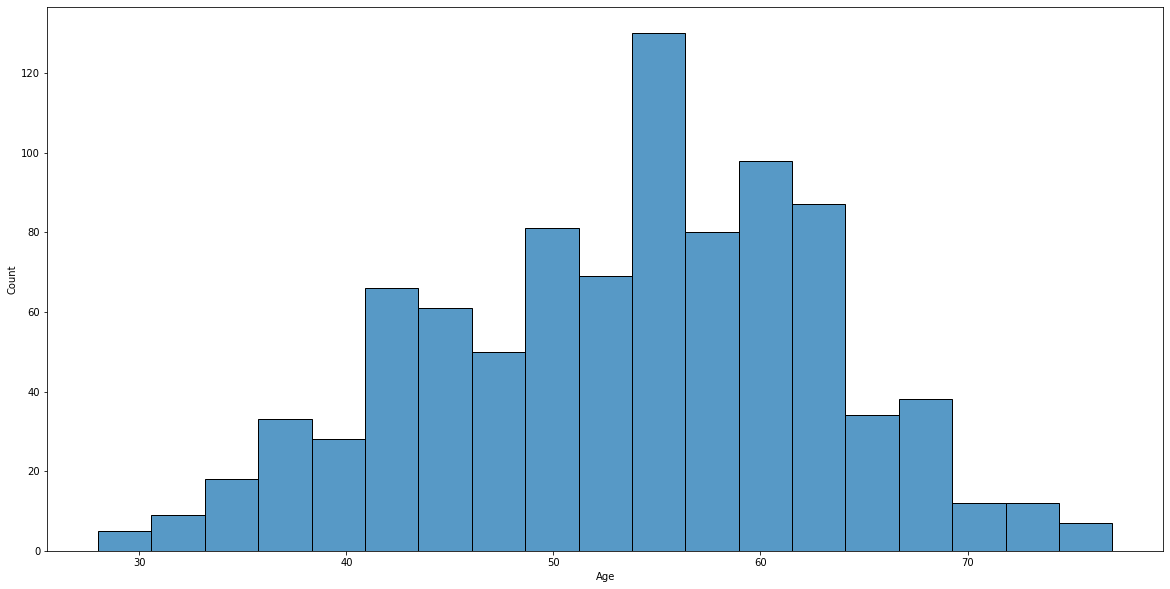

excess kurtosis of normal distribution (should be 0): -0.3905684960842244
skewness of normal distribution (should be 0): -0.19561273124487544


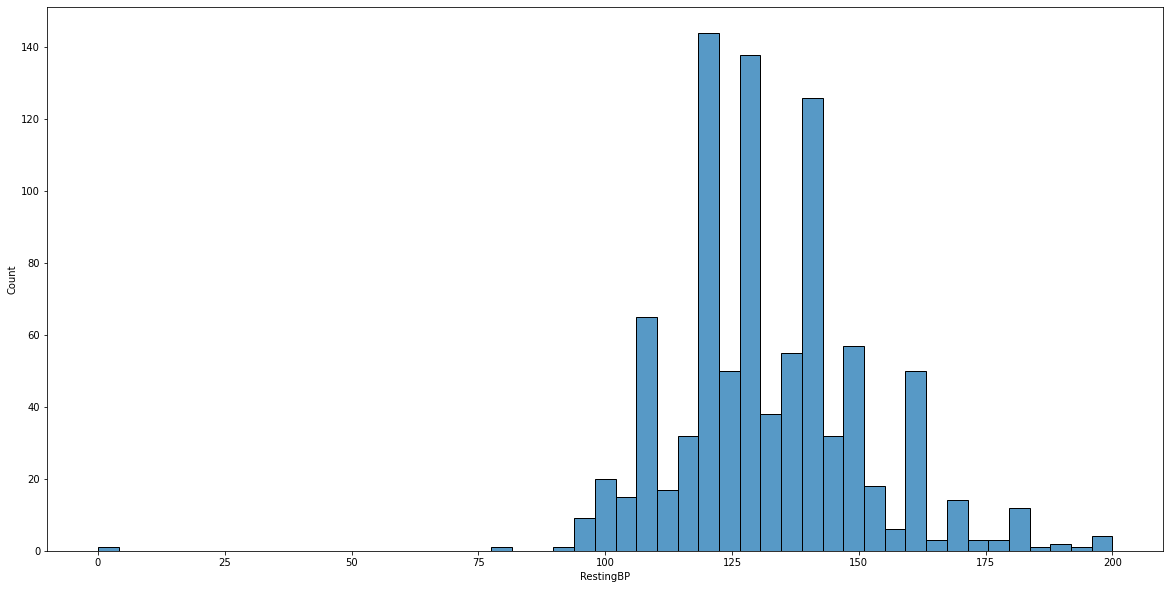

excess kurtosis of normal distribution (should be 0): 3.2469319615478724
skewness of normal distribution (should be 0): 0.17954532149156327


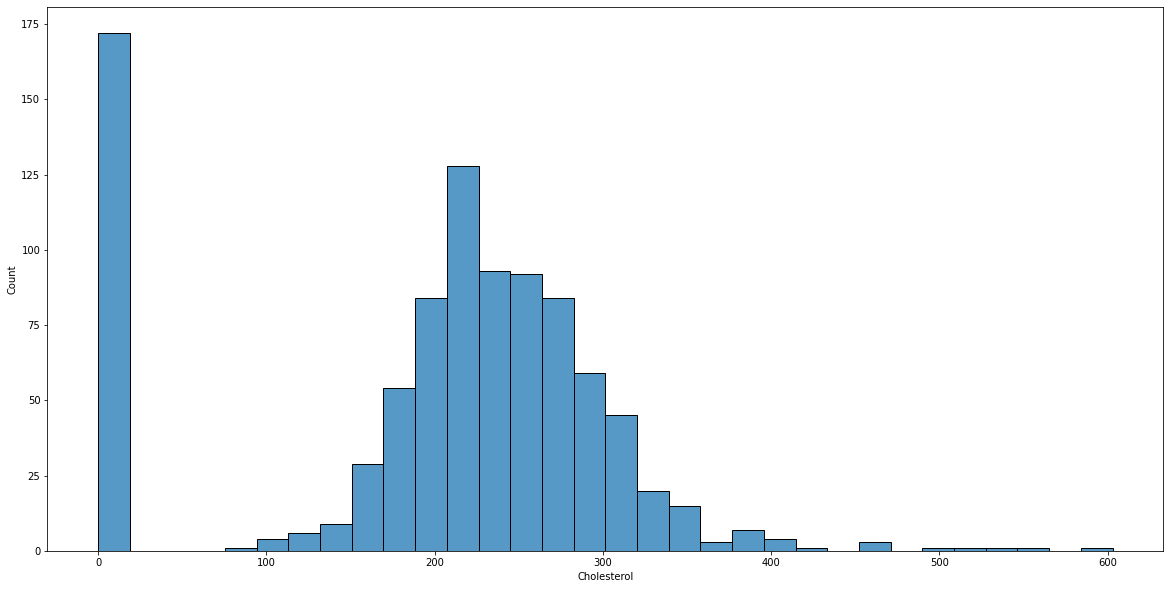

excess kurtosis of normal distribution (should be 0): 0.11103677697582448
skewness of normal distribution (should be 0): -0.6090891046626045


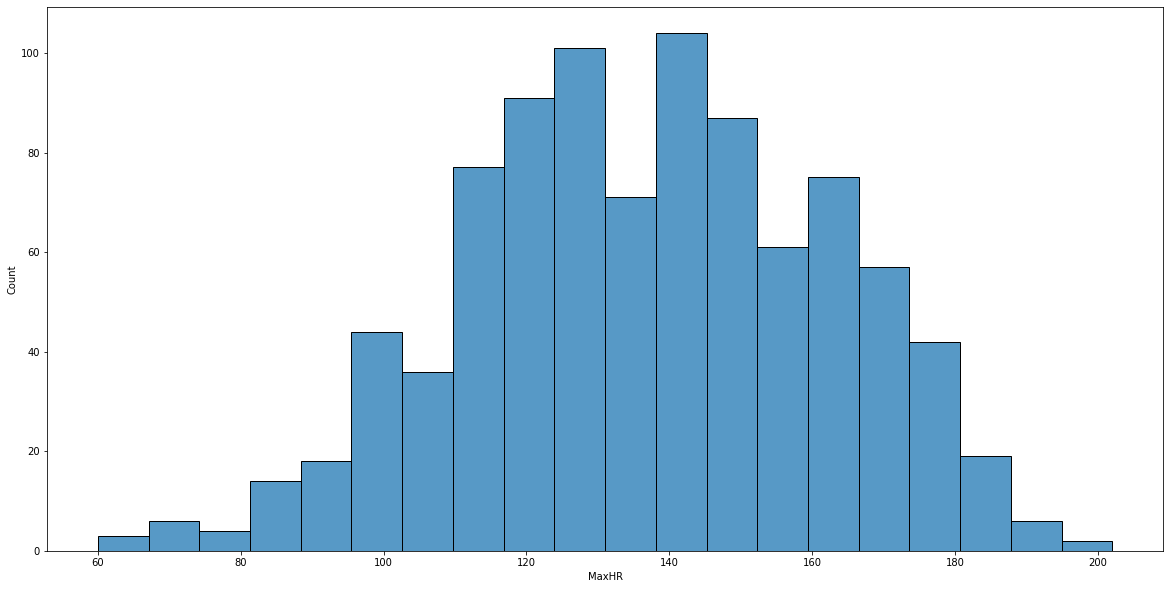

excess kurtosis of normal distribution (should be 0): -0.4523389391469048
skewness of normal distribution (should be 0): -0.14412342991429325


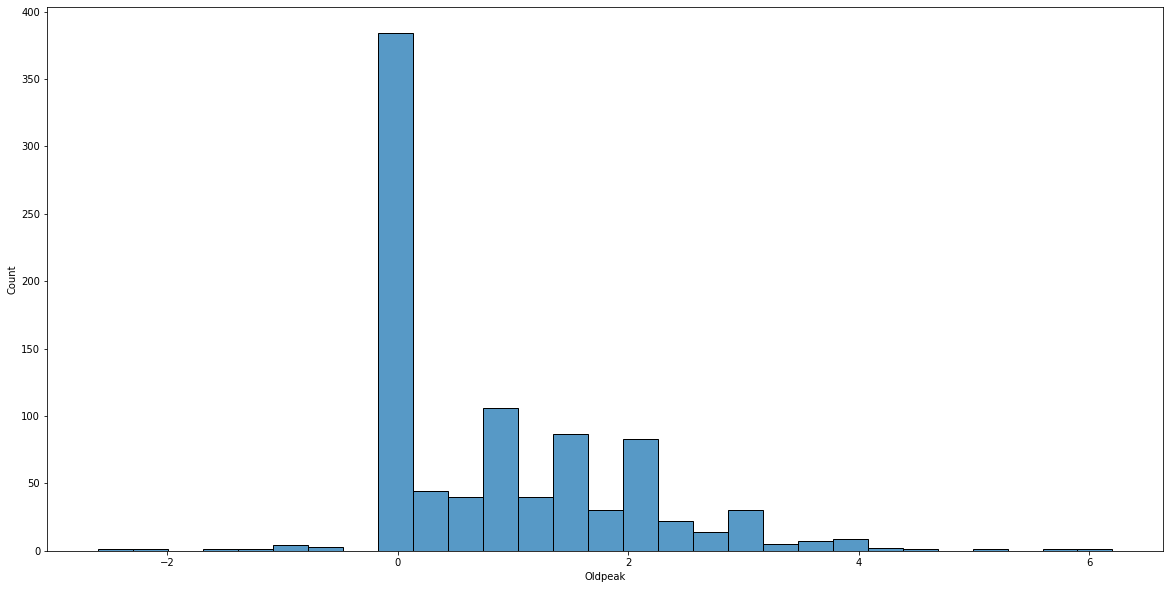

excess kurtosis of normal distribution (should be 0): 1.189992199237265
skewness of normal distribution (should be 0): 1.0211999031135828


In [10]:
for numerical_feature in numerical_features:
    plot_variable_distribution(numerical_feature)
    print( 'excess kurtosis of normal distribution (should be 0): {}'.format(kurtosis(data[f'{numerical_feature}'])))
    print( 'skewness of normal distribution (should be 0): {}'.format(skew(data[f'{numerical_feature}'])))

###### Categorical Features

In [11]:
def plot_categorical_feature_distribution(variable_name):
    plt.figure(figsize=(20, 10))
    ax = sns.countplot(x=f"{variable_name}", data=data)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)
    plt.xlabel(f"{column}")
    plt.savefig(f"../results/EDA/{variable_name}_distribution.png")
    plt.show()
    plt.close()

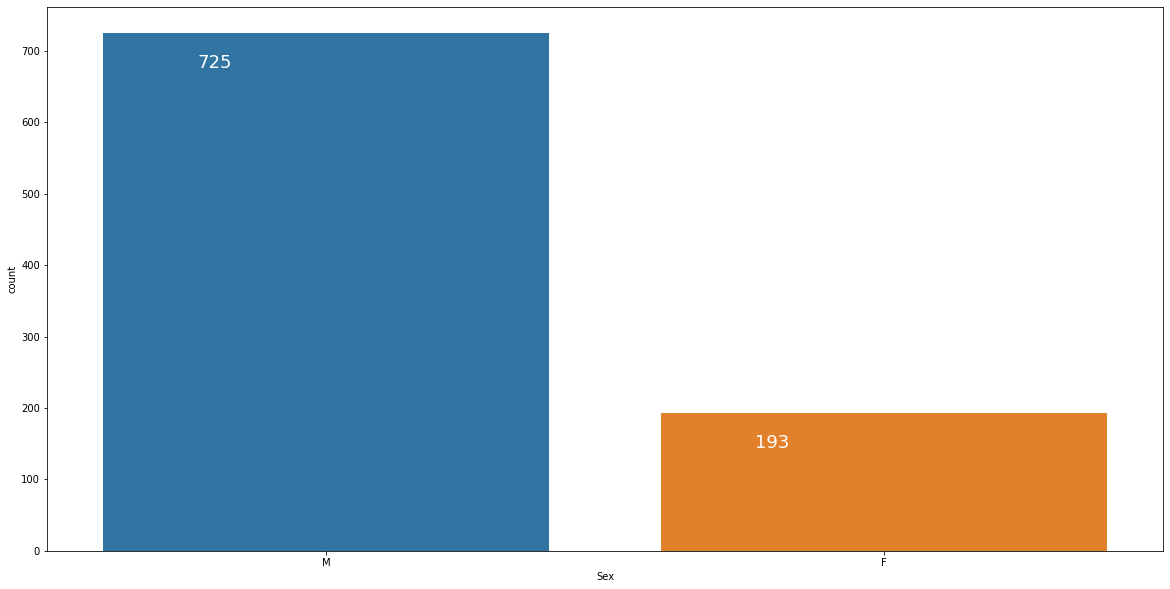

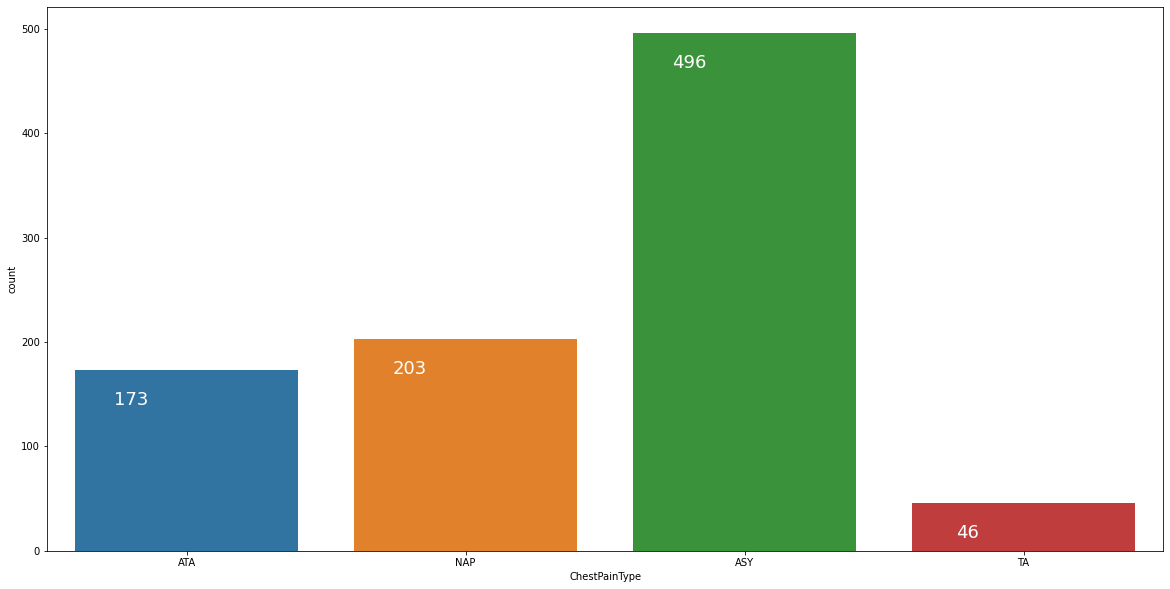

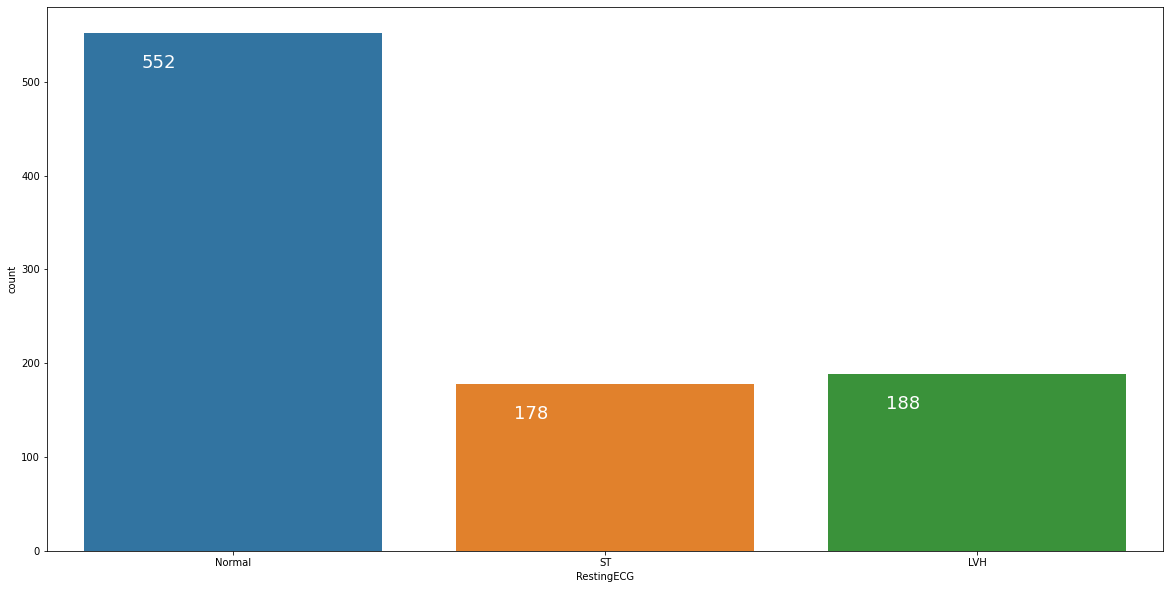

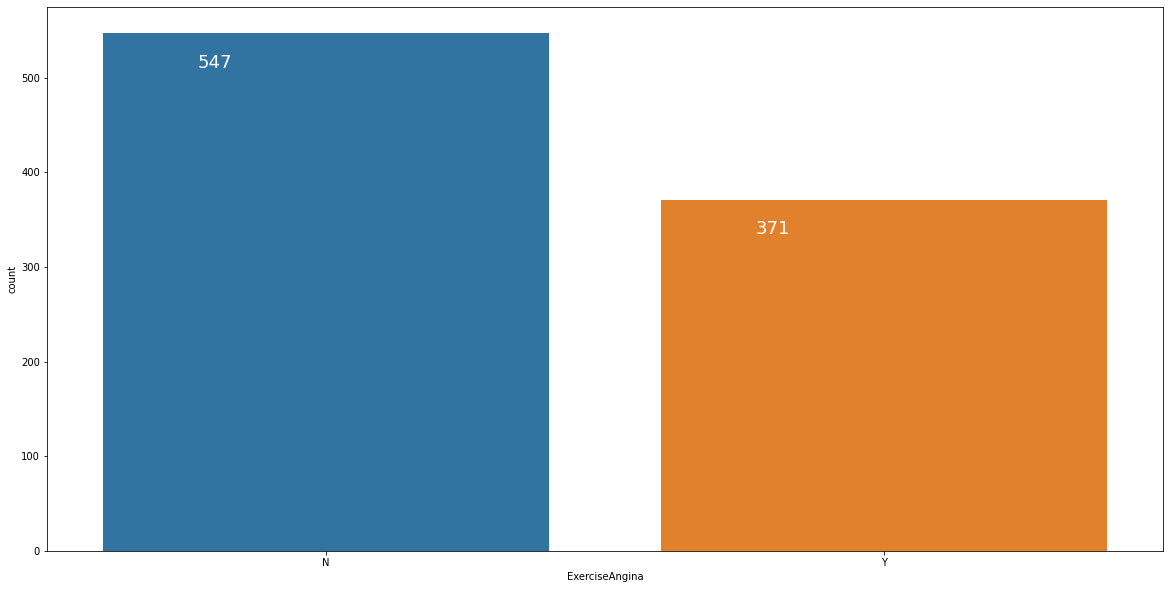

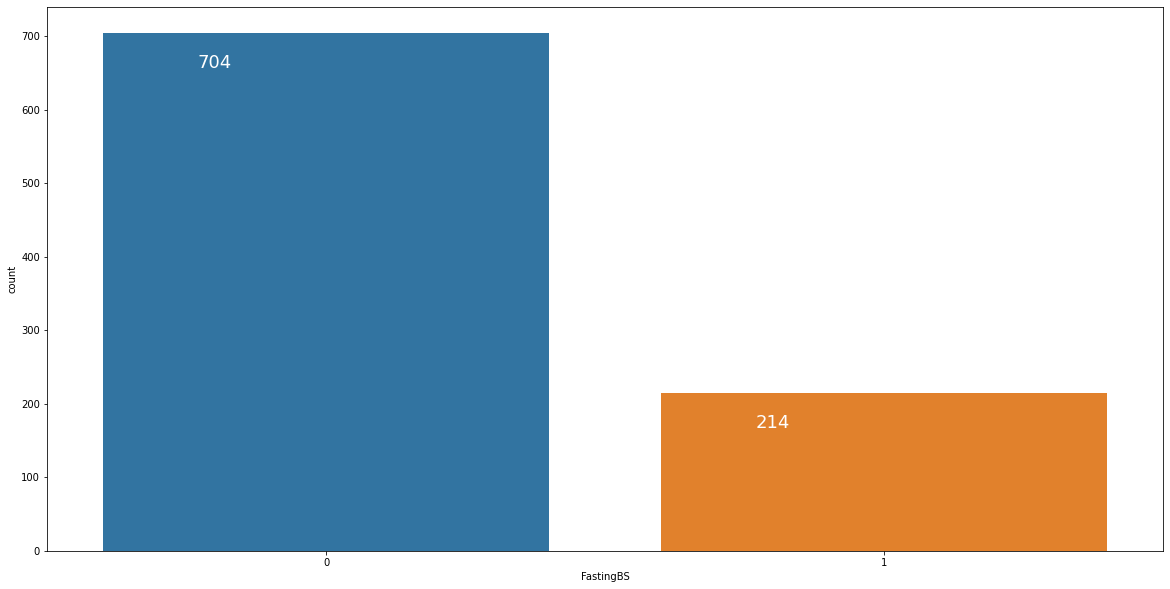

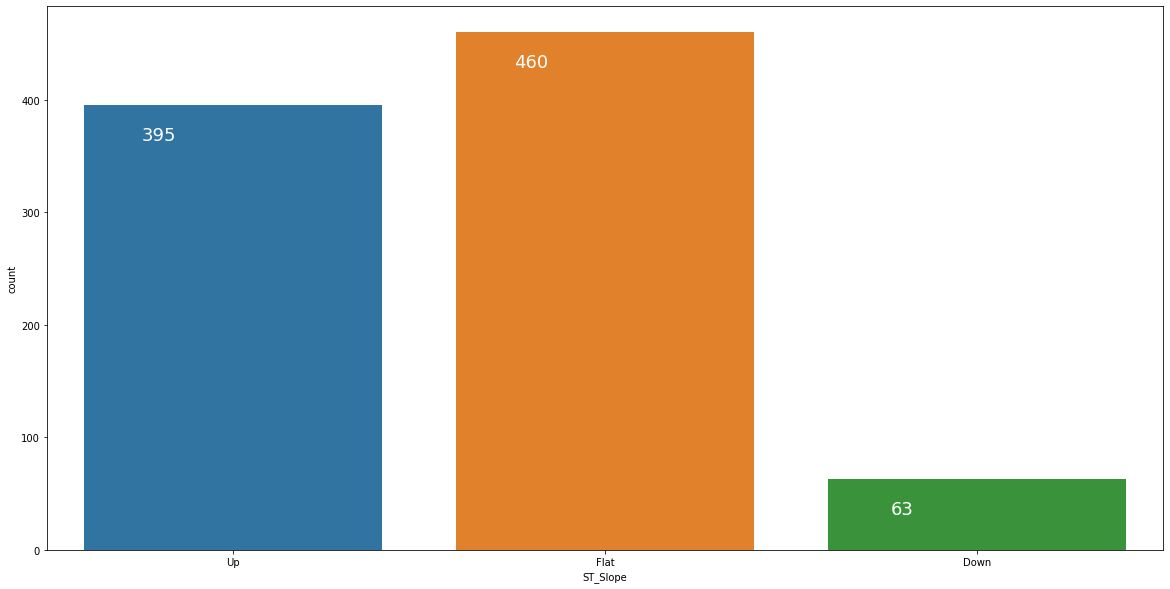

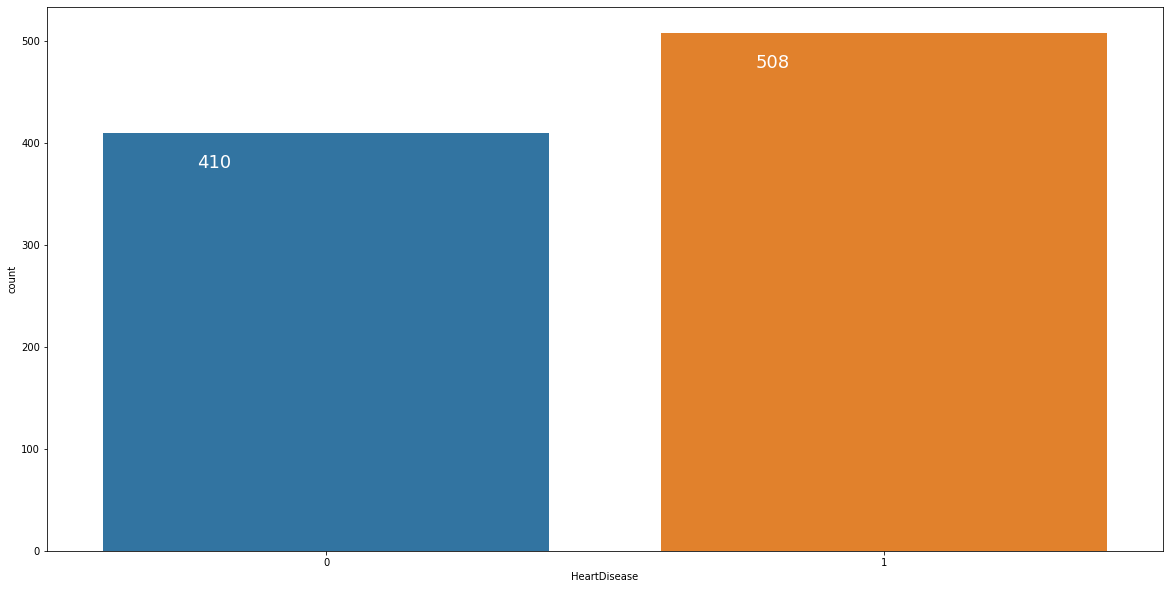

In [12]:
for column in categorical_features: 
    plot_categorical_feature_distribution(column)

We can conclude that the dataset is not imbalaced, since there is no minorty class and we have a almost 50 / 50 ratio between those how suffered a heart failure and those that no

In [13]:
symetric_distribution_features = ['Age', 'Cholesterol', 'MaxHR']

In [14]:
asymetric_distribution_features = ['RestingBP', 'Oldpeak']

In [15]:
# Dataset 1 is the raw dataset, variables will not have any modification in here
dataset_1 = data.copy()

### Missing Values

<AxesSubplot:>

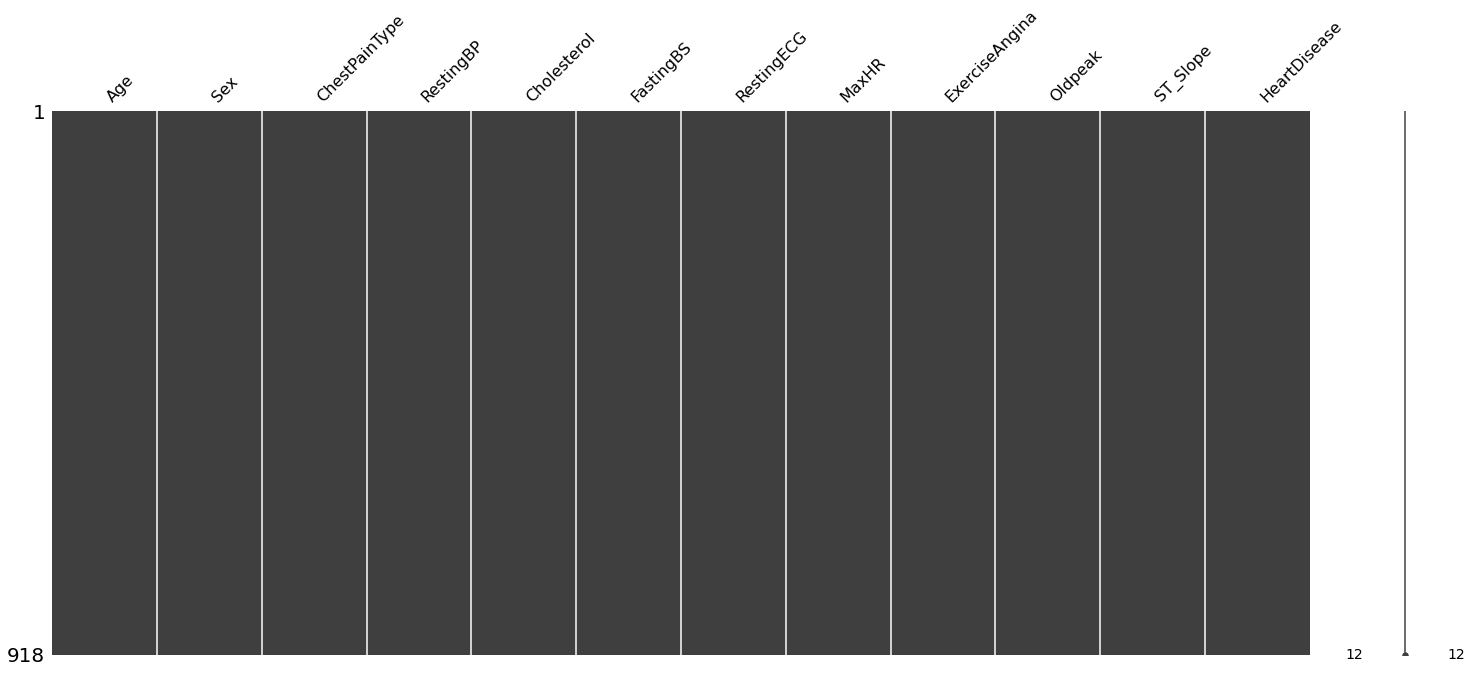

In [16]:
msno.matrix(data)

<AxesSubplot:>

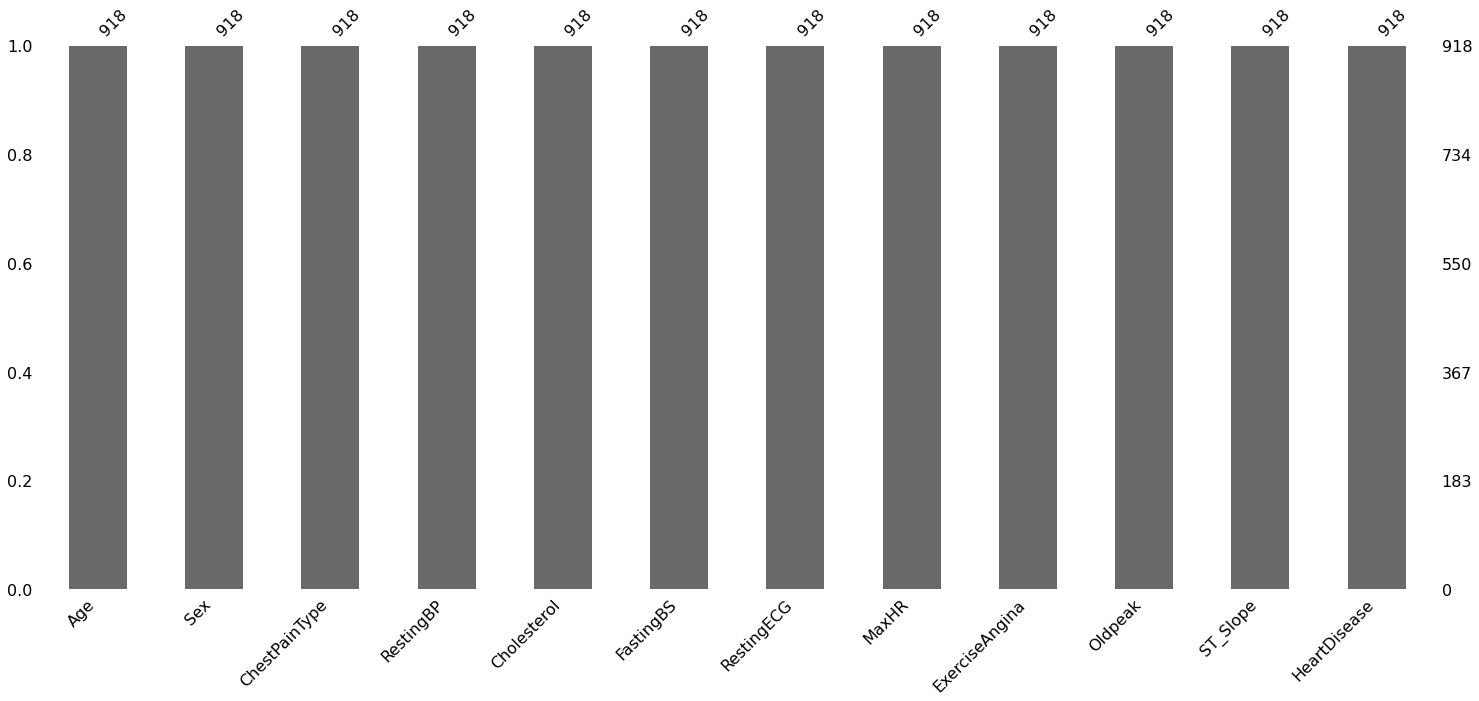

In [17]:
msno.bar(data)

There are no missing values in this dataset. But there are some anomalies in the cholesterol feature.

In [18]:
# Count number of zeros in all columns of Dataframe to detect possible wrong values
for column_name in data.columns:
    column = data[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print(f'Count of zeros in column: {column_name} is {count}, {count/data.shape[0]*100} % of the data ')

Count of zeros in column: Age is 0, 0.0 % of the data 
Count of zeros in column: Sex is 0, 0.0 % of the data 
Count of zeros in column: ChestPainType is 0, 0.0 % of the data 
Count of zeros in column: RestingBP is 1, 0.10893246187363835 % of the data 
Count of zeros in column: Cholesterol is 172, 18.736383442265794 % of the data 
Count of zeros in column: FastingBS is 704, 76.68845315904139 % of the data 
Count of zeros in column: RestingECG is 0, 0.0 % of the data 
Count of zeros in column: MaxHR is 0, 0.0 % of the data 
Count of zeros in column: ExerciseAngina is 0, 0.0 % of the data 
Count of zeros in column: Oldpeak is 368, 40.08714596949891 % of the data 
Count of zeros in column: ST_Slope is 0, 0.0 % of the data 
Count of zeros in column: HeartDisease is 410, 44.66230936819172 % of the data 


#### Cholesterol

In [19]:
number_of_zeroes = data['Cholesterol'][data['Cholesterol'] == 0].count()
print(f'There are {number_of_zeroes} 0´s in Cholesterol')

There are 172 0´s in Cholesterol


#### Resting BP

In [20]:
number_of_zeroes = data['RestingBP'][data['RestingBP'] == 0].count()
print(f'There are {number_of_zeroes} 0´s in RestingBP')

There are 1 0´s in RestingBP


#### Mean Inputation

In [21]:
dataset_2_1 = data.copy()
dataset_2_1['Cholesterol']=dataset_2_1['Cholesterol'].mask(dataset_2_1['Cholesterol']==0).fillna(dataset_2_1['Cholesterol'].mean())
dataset_2_1['RestingBP']=dataset_2_1['RestingBP'].mask(dataset_2_1['RestingBP']==0).fillna(dataset_2_1['RestingBP'].mean())

#### Regression Inputation

In [22]:
dataset_2_2 = data.copy()
dataset_2_2['Cholesterol']=dataset_2_2['Cholesterol'].mask(dataset_2_2['Cholesterol']==0)
dataset_2_2['RestingBP']=dataset_2_2['RestingBP'].mask(dataset_2_2['RestingBP']==0)
# imputer = IterativeImputer(random_state=42)
# imputed = imputer.fit_transform(dataset_2_2)
# dataset_2_2 = pd.DataFrame(imputed, columns=dataset_2_2.columns)

### Outlier Detection

In [23]:
def mean_3_std(variable_name):
    data_mean, data_std = np.mean(data[f'{variable_name}']), np.std(data[f'{variable_name}'])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers_lower = [x for x in data[f'{variable_name}'] if x < lower]
    outliers_upper = [x for x in data[f'{variable_name}'] if x > upper]
    print(f'Variable {variable_name}: Lower outliers {outliers_lower}, Upper outliers {outliers_upper}, boundaries {lower}, {upper}')

In [24]:
def plot_intercuartile_range(variable_name):
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=data, x=f"{variable_name}")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/{variable_name}_outliers.png")
    plt.show()
    plt.close()

In [25]:
for symetric_distribution_feature in symetric_distribution_features:
    mean_3_std(symetric_distribution_feature)

Variable Age: Lower outliers [], Upper outliers [], boundaries 25.22846069772688, 81.79332579464784
Variable Cholesterol: Lower outliers [], Upper outliers [529, 603, 564], boundaries -129.1740884232252, 526.7732169635302
Variable MaxHR: Lower outliers [60], Upper outliers [], boundaries 60.46997896579296, 213.14875741764928


In [26]:
def iqr(variable_name):
    q75, q25 = np.percentile(data[f'{variable_name}'], [75 ,25])
    iqr = q75 - q25
    lower = q25 - iqr*1.5
    upper = q75 + iqr*1.5
    outliers_lower = [x for x in data[f'{variable_name}'] if x < lower]
    outliers_upper = [x for x in data[f'{variable_name}'] if x > upper]
    print(f'Variable {variable_name}: Lower outliers {outliers_lower}, {len(outliers_lower)}, Upper outliers {outliers_upper}, {len(outliers_upper)}, boundaries {lower}, {upper}')

In [27]:
for asymetric_distribution_feature in asymetric_distribution_features:
    iqr(asymetric_distribution_feature)

Variable RestingBP: Lower outliers [80, 0], 2, Upper outliers [190, 180, 180, 180, 200, 180, 180, 180, 200, 185, 200, 180, 180, 178, 172, 180, 190, 174, 178, 180, 200, 192, 178, 180, 180, 172], 26, boundaries 90.0, 170.0
Variable Oldpeak: Lower outliers [-2.6], 1, Upper outliers [4.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.2, 4.0, 5.6, 3.8, 4.2, 6.2, 4.4, 4.0], 15, boundaries -2.25, 3.75


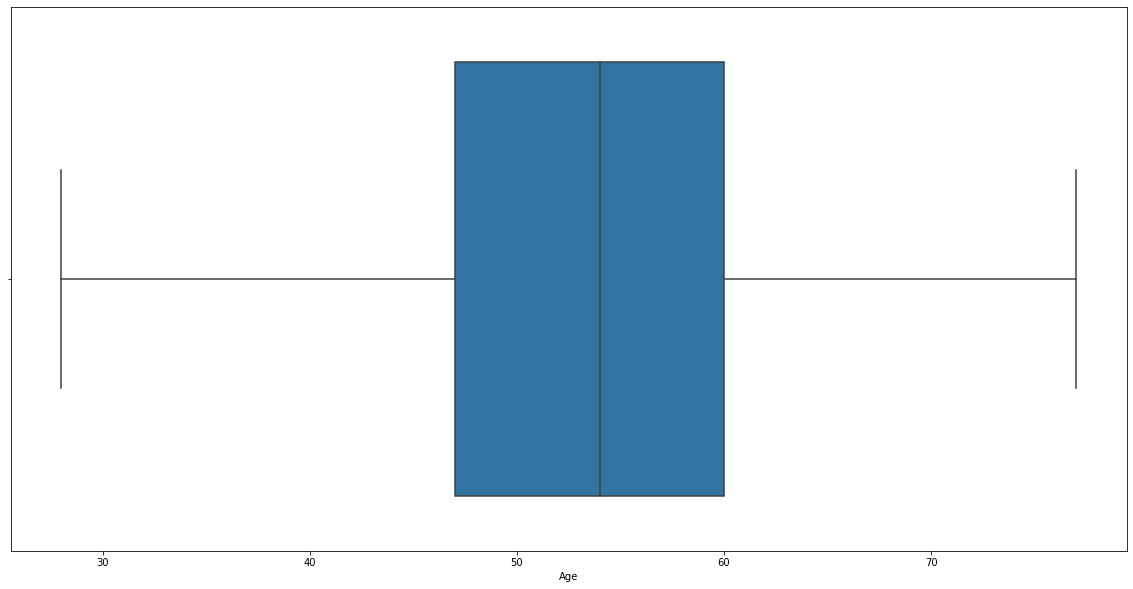

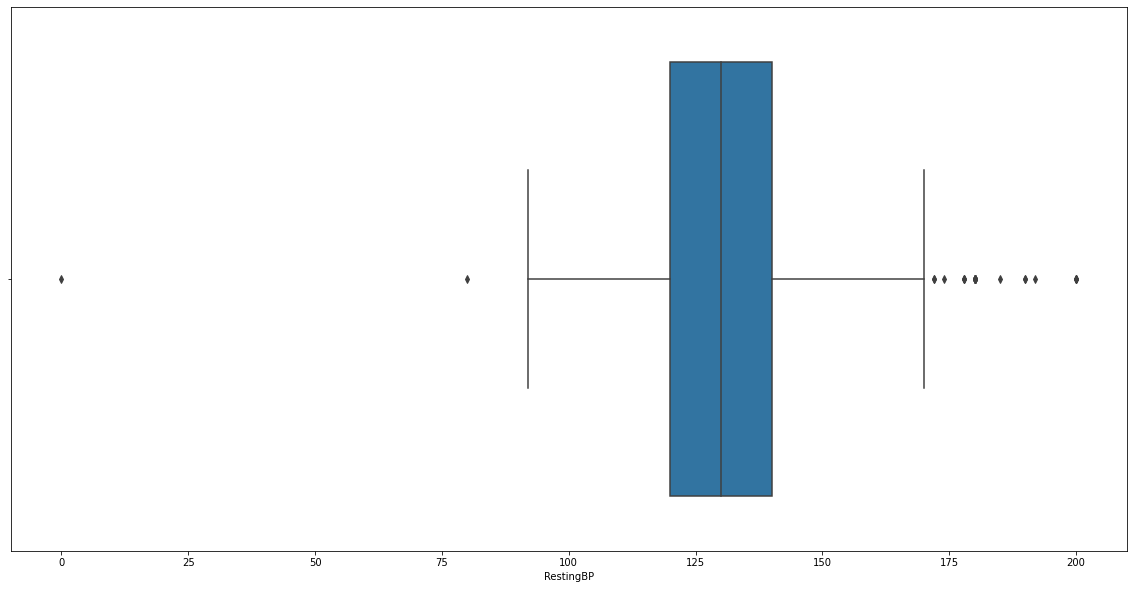

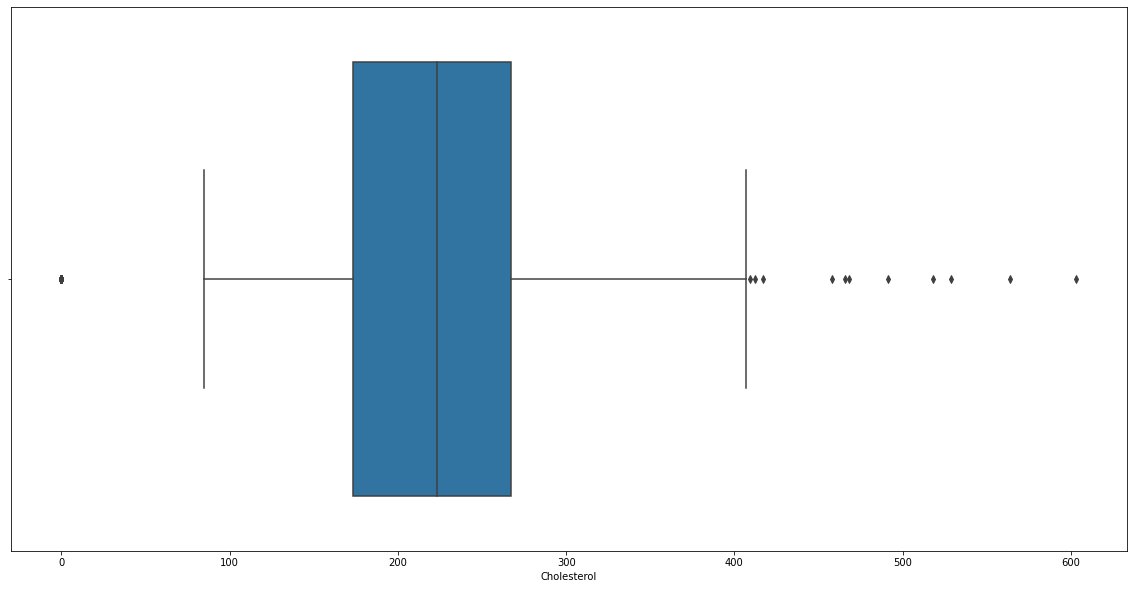

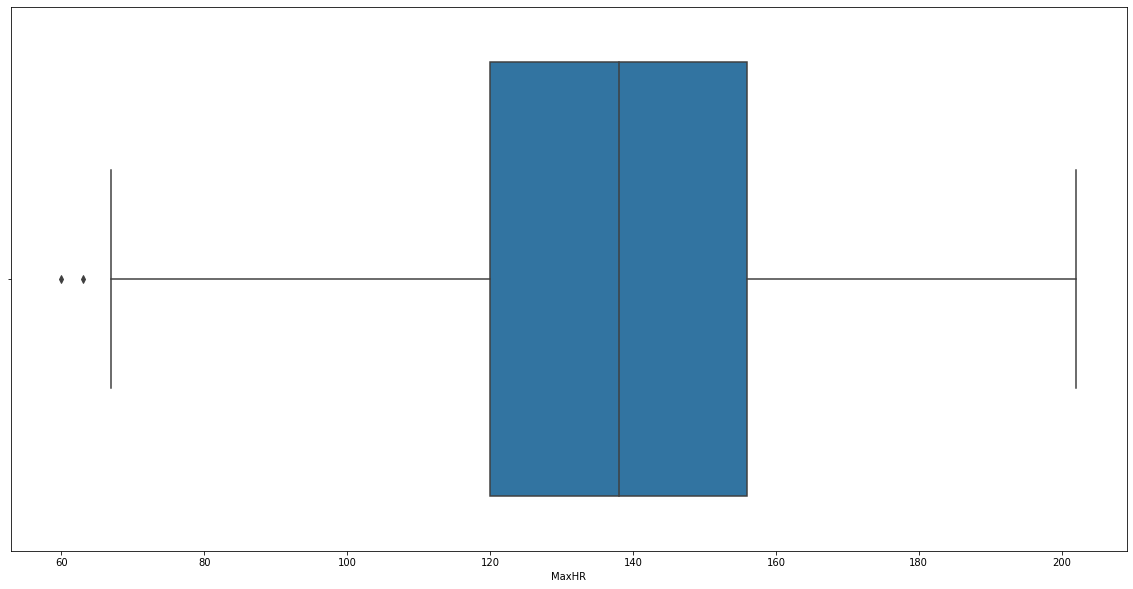

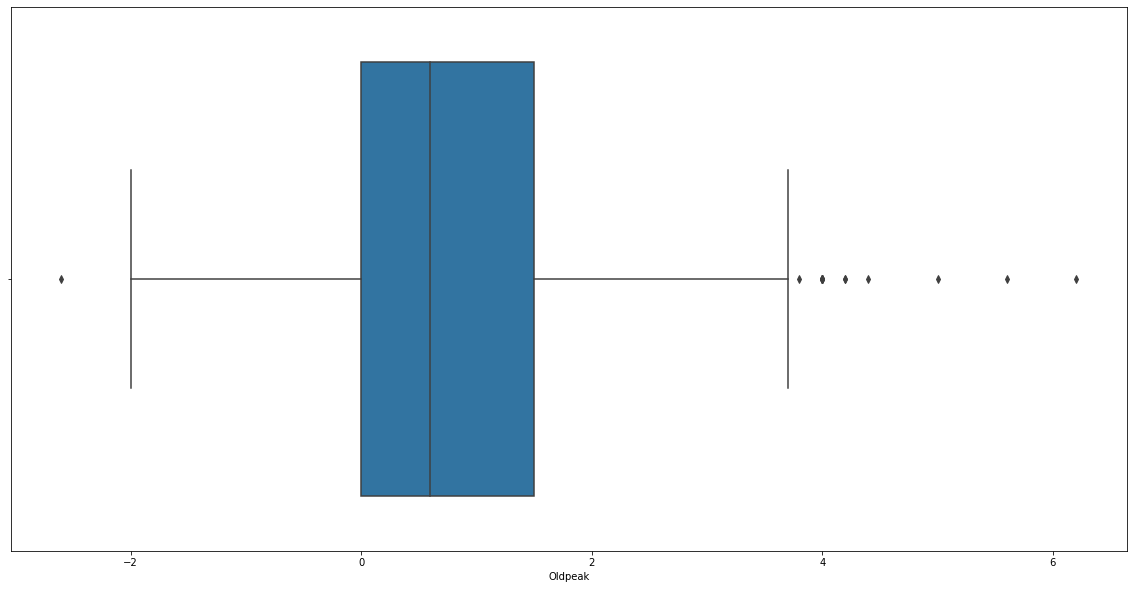

In [28]:
for numerical_feature in numerical_features:
    plot_intercuartile_range(numerical_feature)

### Multivariate Analysis

The target column in this case is very clear, HeartDisease. We already know that it is not balanced, but know we will try to detect any pattern. 

#### Numerical features: Plots

In [29]:
def distribution_acording_to_target_value(variable_name):
    plt.figure(figsize=(20, 10))
    plt.title(f"Distribution of {variable_name}")
    ax = sns.violinplot(x="HeartDisease", y=f"{variable_name}",
                    data=data, palette="Set2", split=True,
                    scale="count")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/violin_{variable_name}.png")
    plt.show()
    plt.close()
    
    plt.figure(figsize=(20, 10))
    ax = sns.boxplot(x="HeartDisease", y=f"{variable_name}", data=data, palette="Set2")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/distribution_{variable_name}_target.png")
    plt.show()
    plt.close()

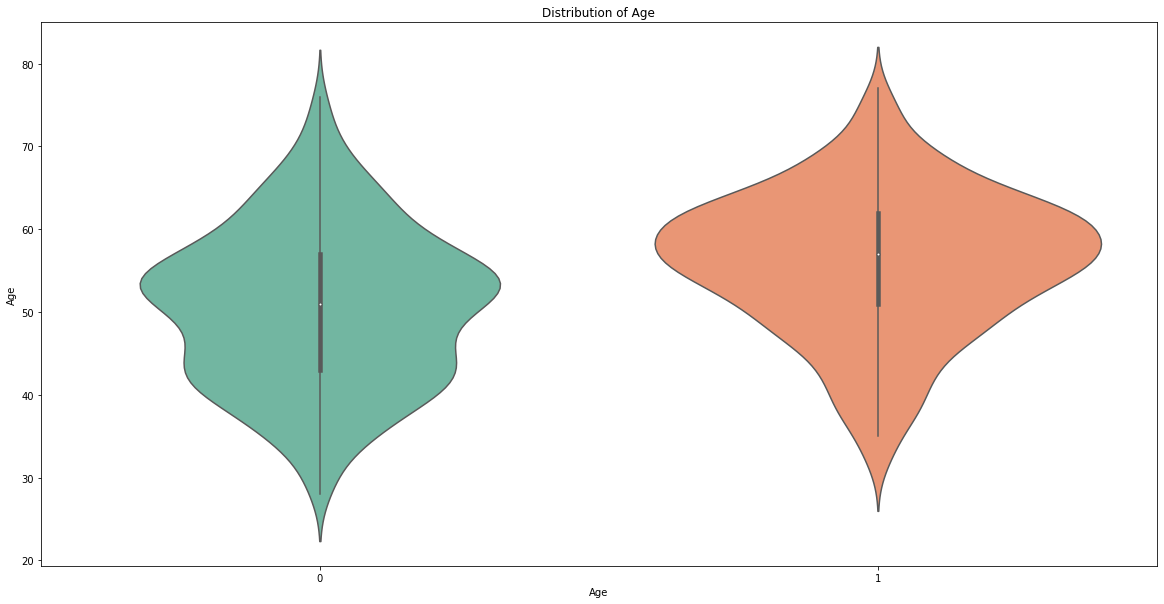

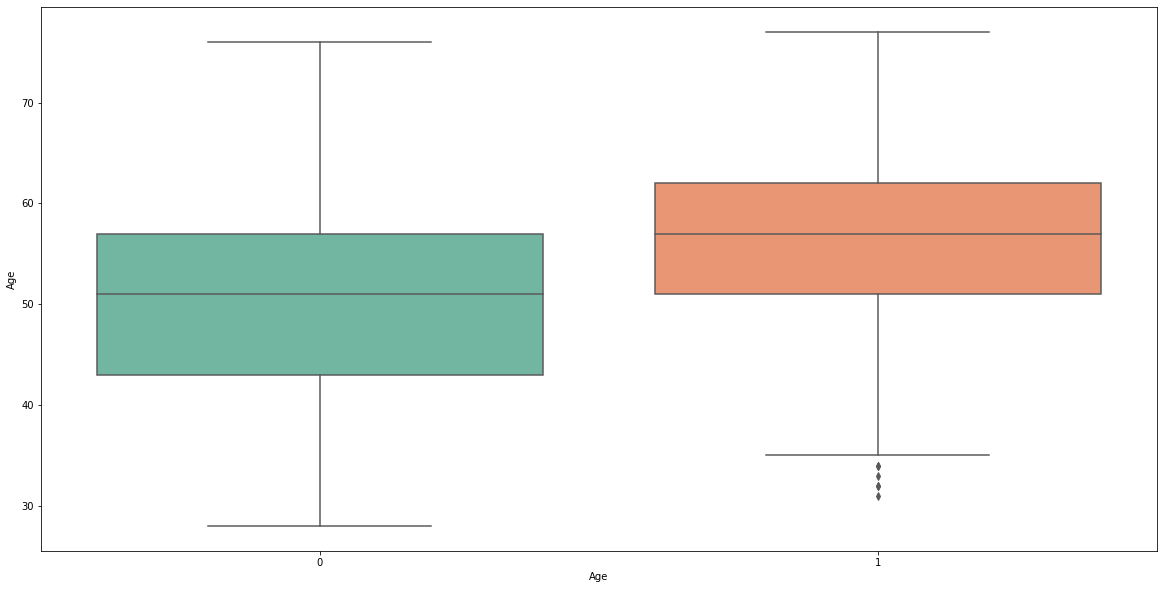

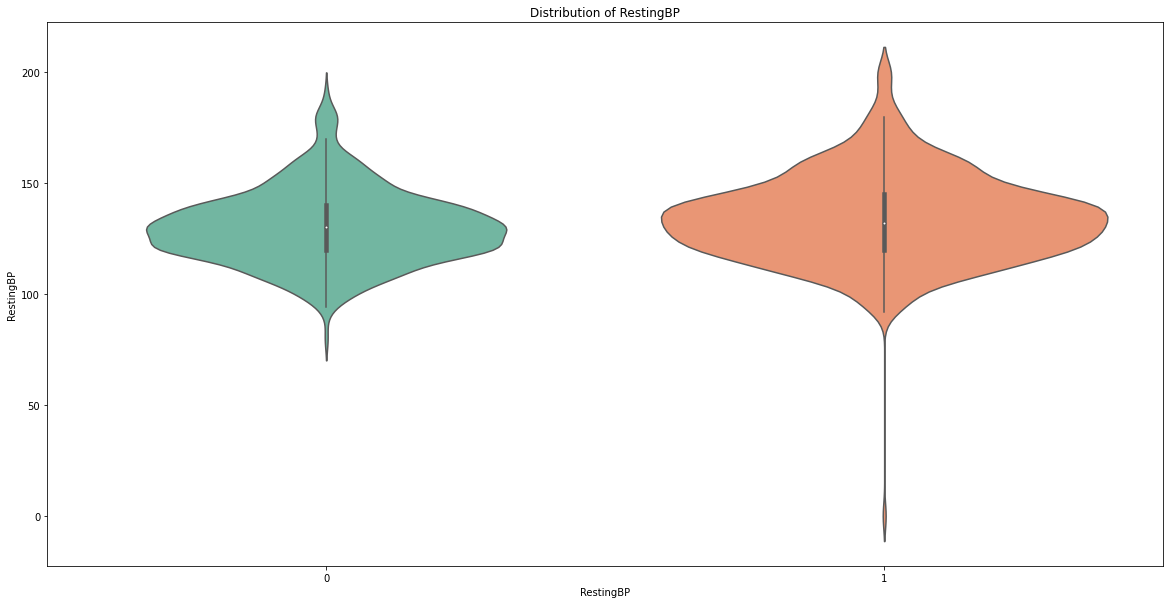

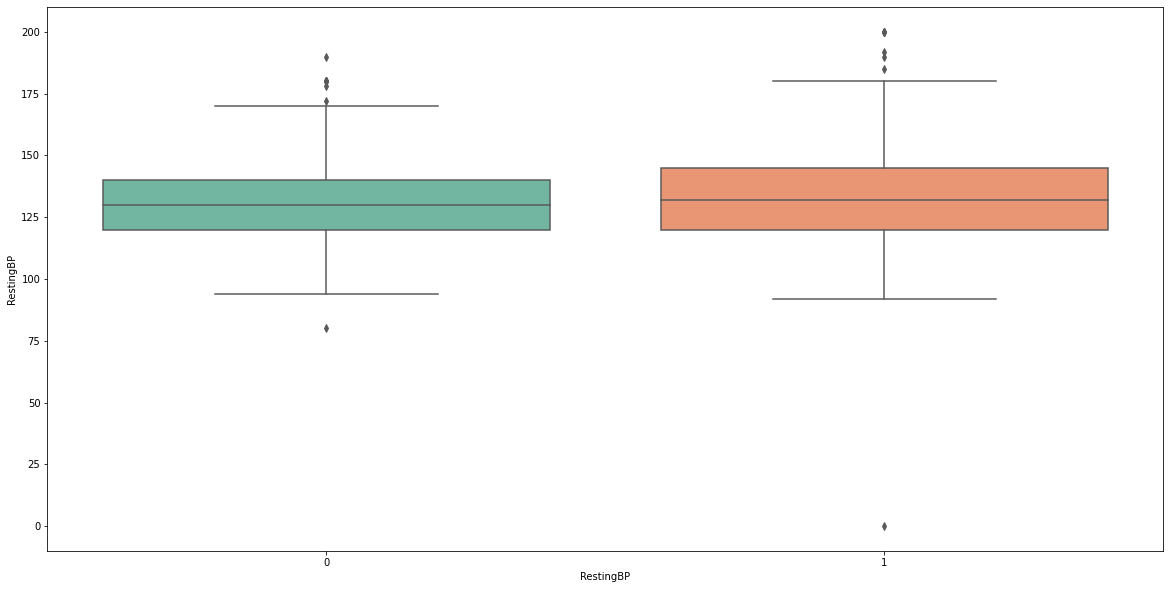

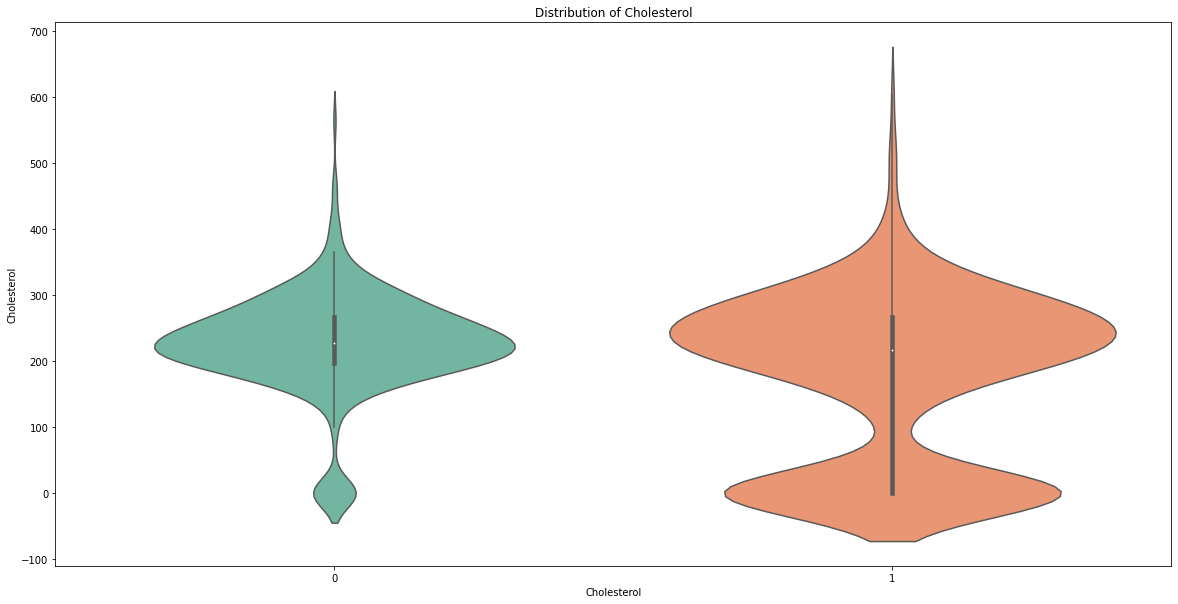

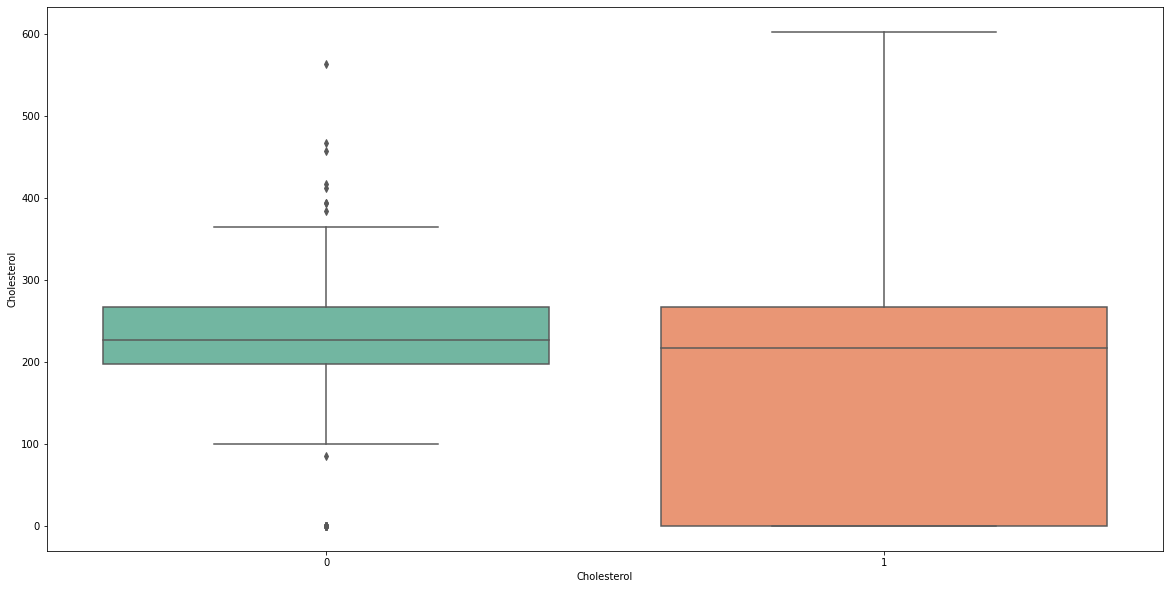

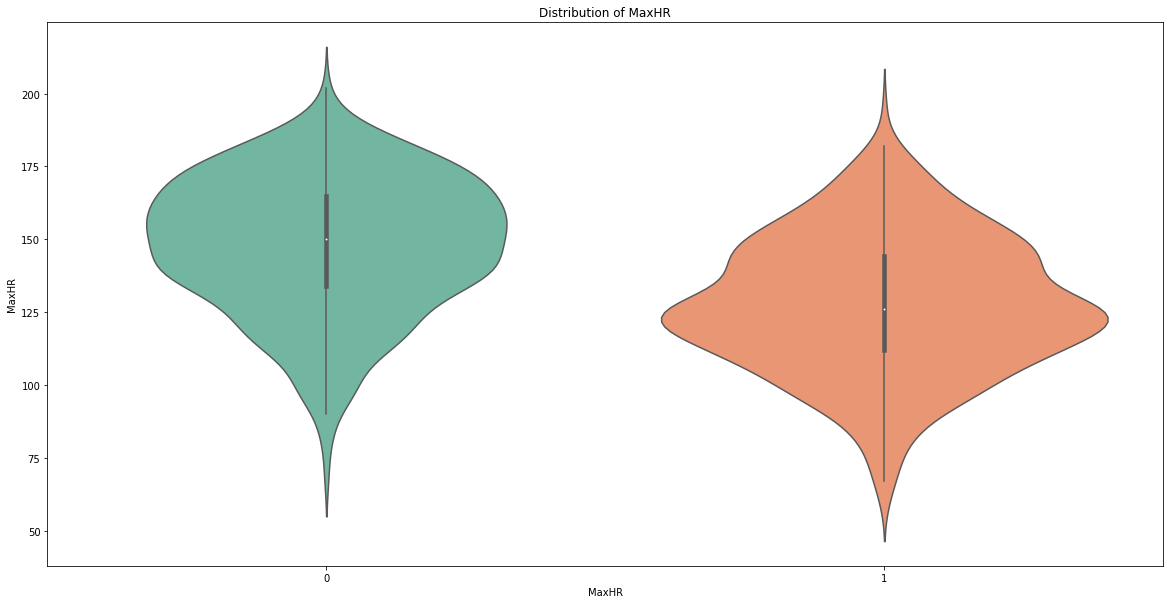

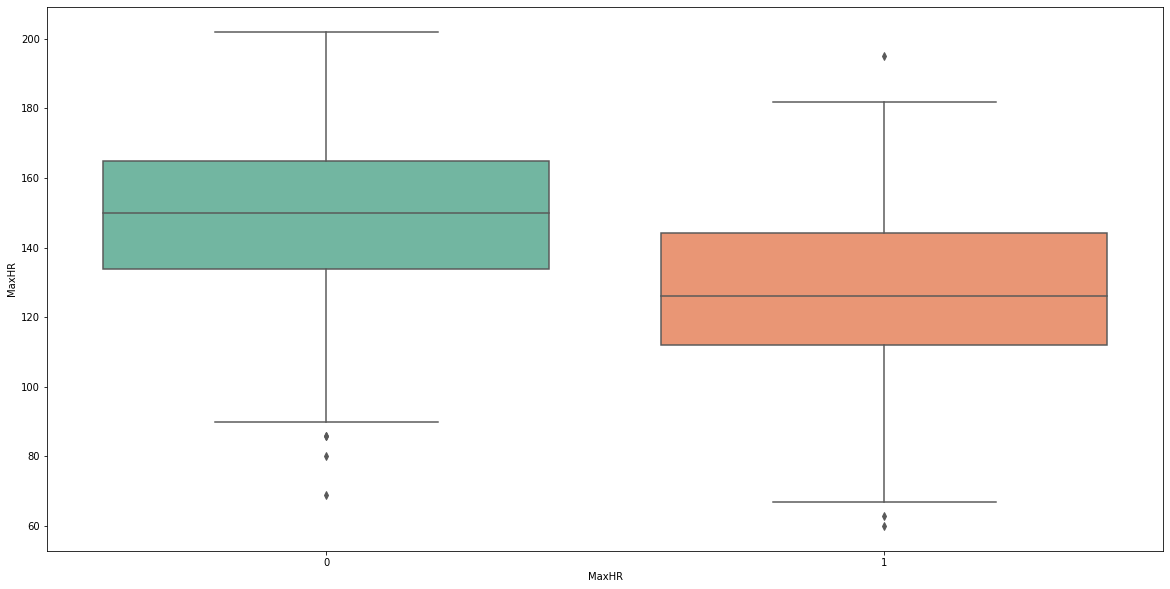

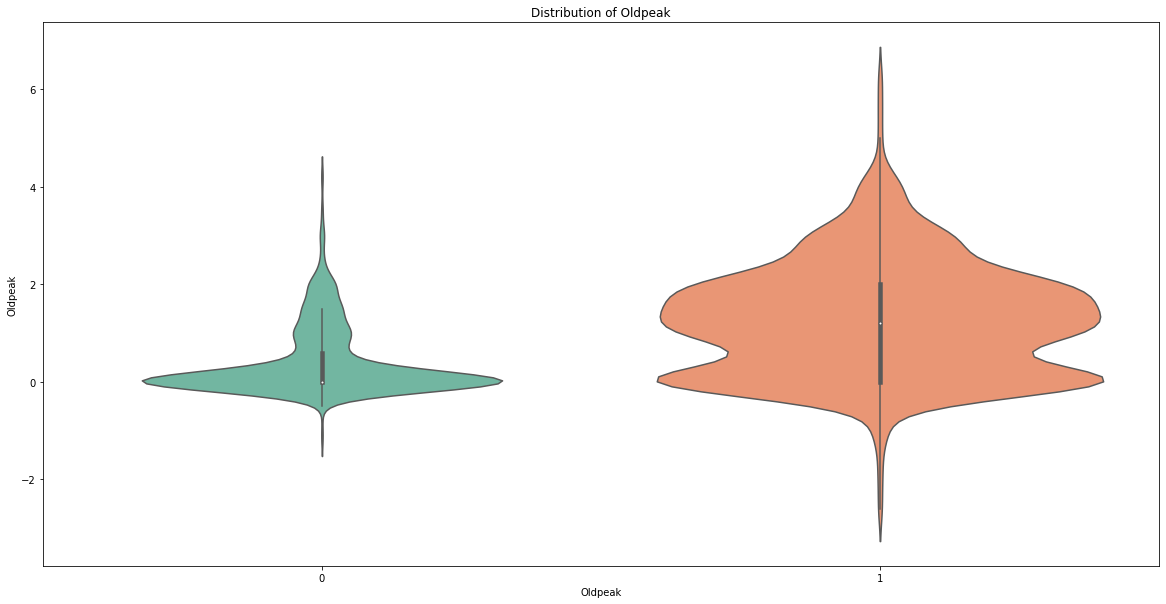

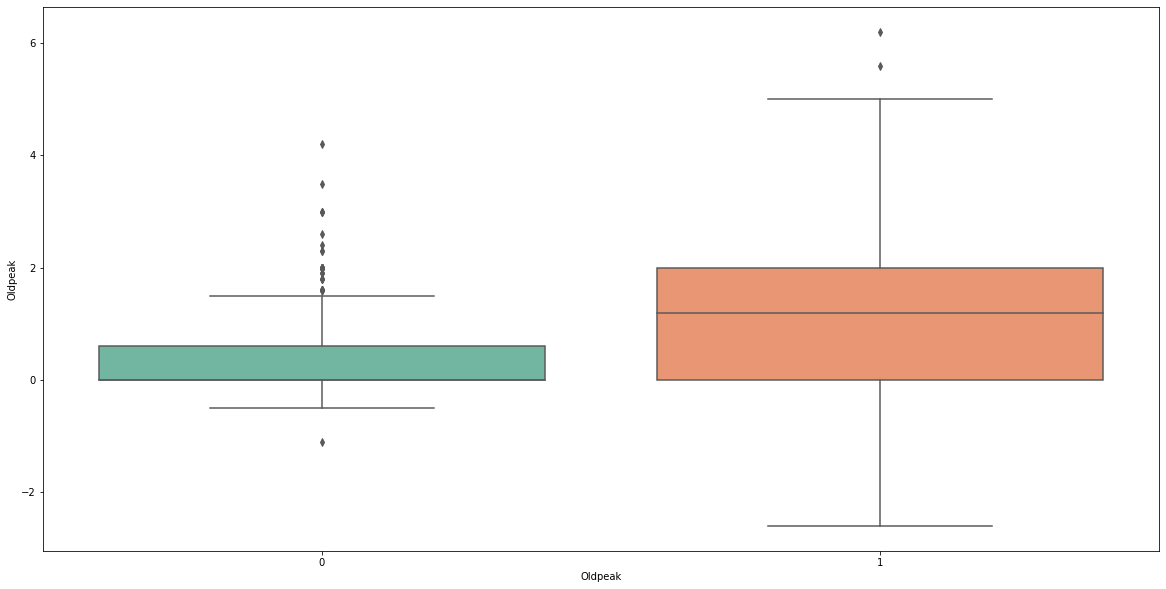

In [30]:
for numerical_feature in numerical_features: 
    distribution_acording_to_target_value(numerical_feature)
    

#### Categorical features: Plots

In [31]:
def categorical_distribution_acording_to_target_value(variable_name):
    plt.figure(figsize=(20, 10))
    plt.title(f"Distribution of {variable_name}")
    ax = sns.countplot(x=f"{variable_name}", hue="HeartDisease", data=data)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=14)
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/distribution_{variable_name}_targetb.png")
    plt.show()
    plt.close()

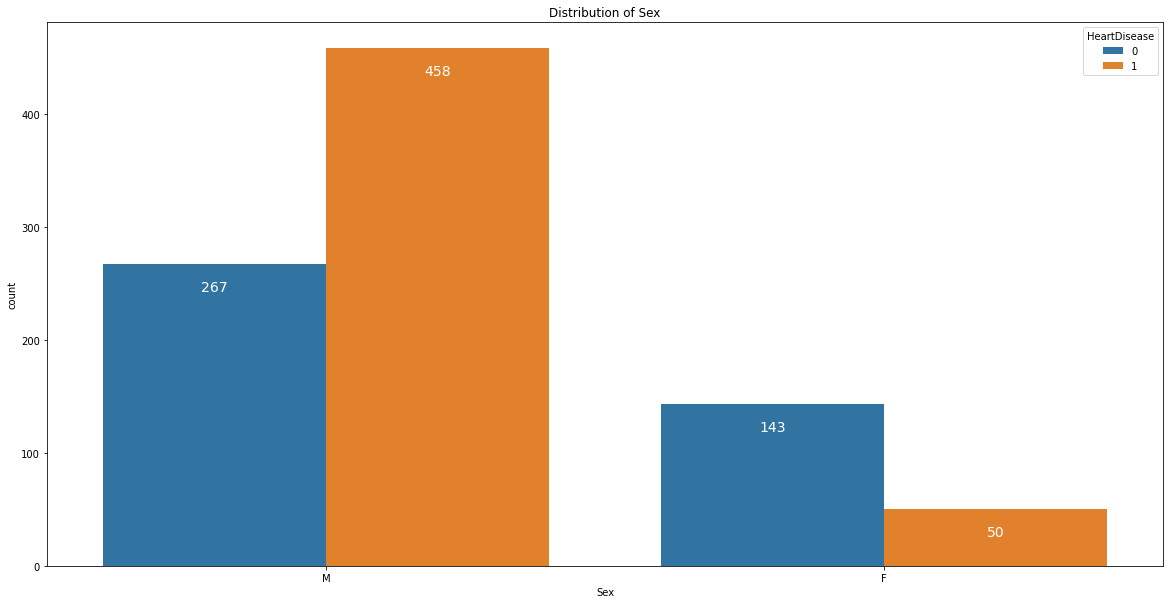

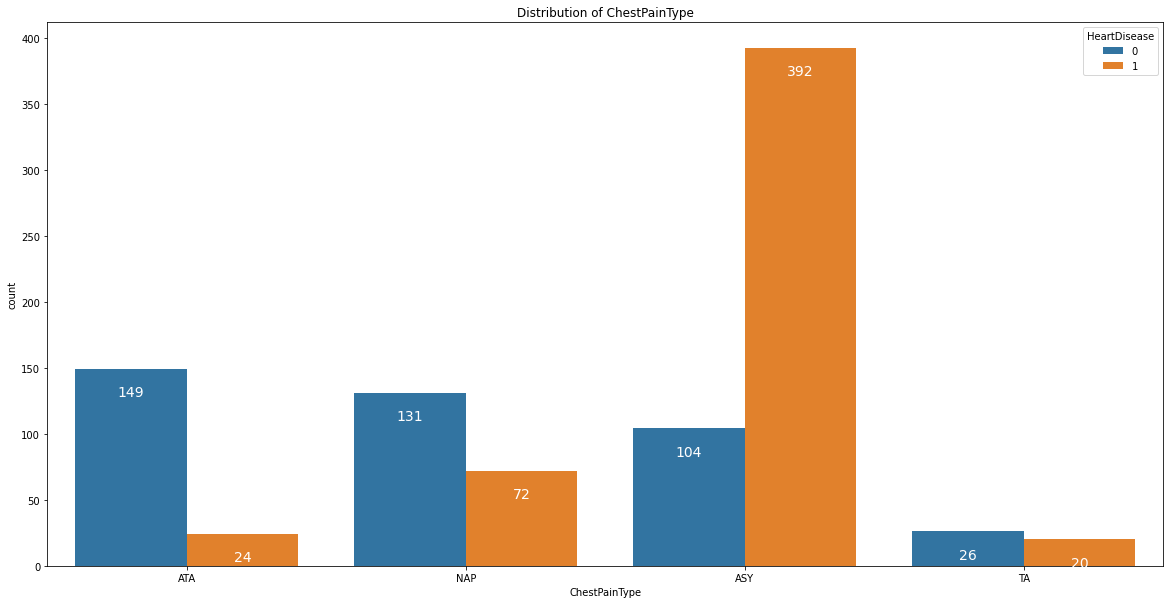

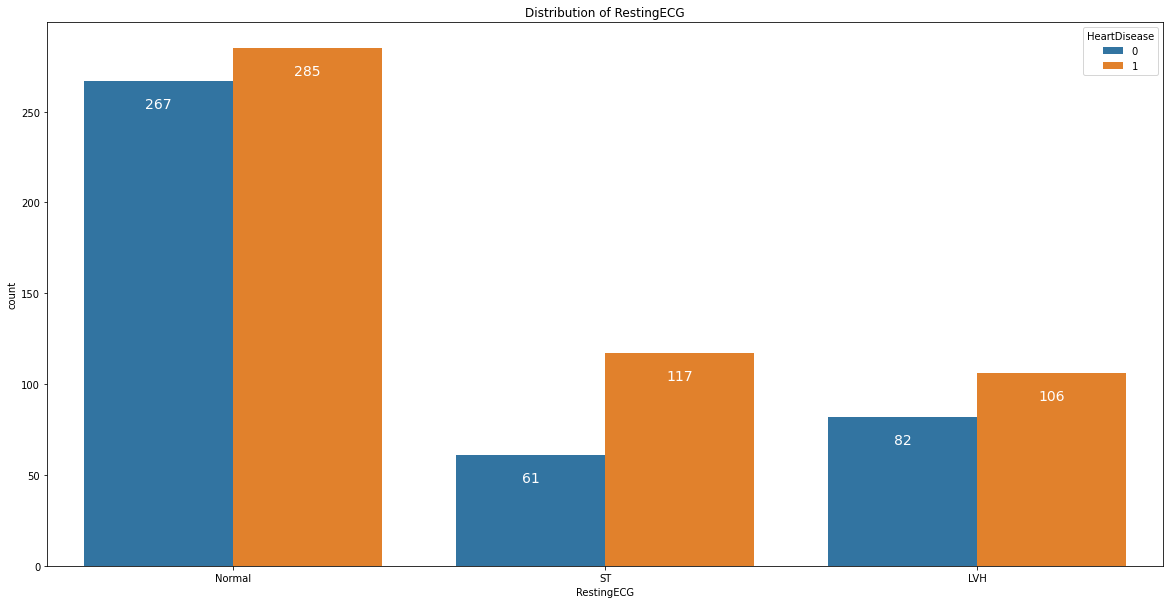

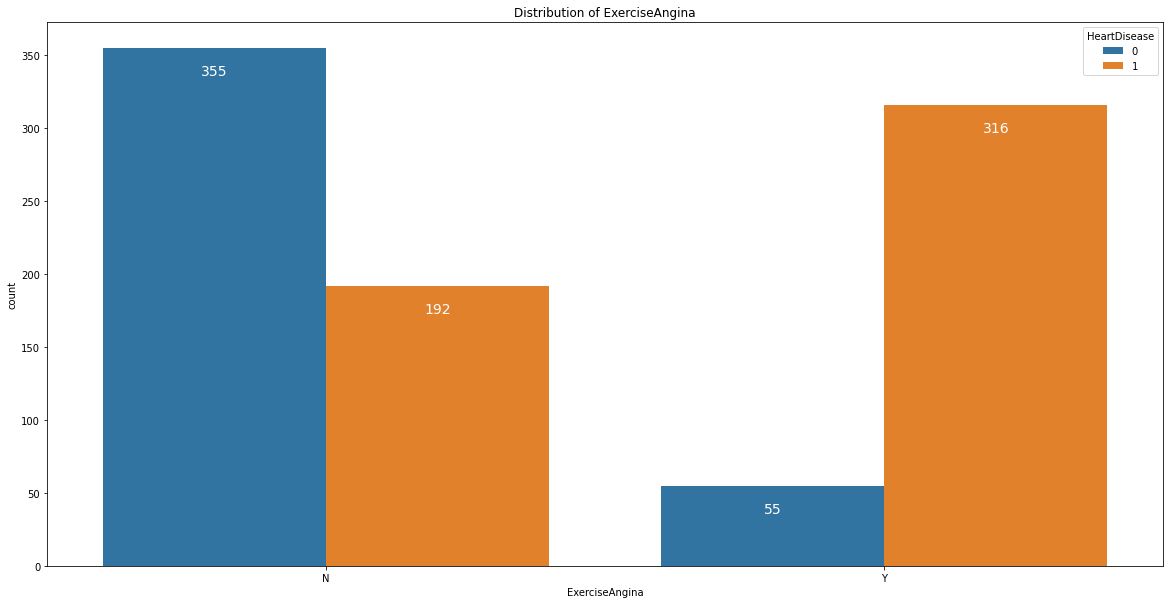

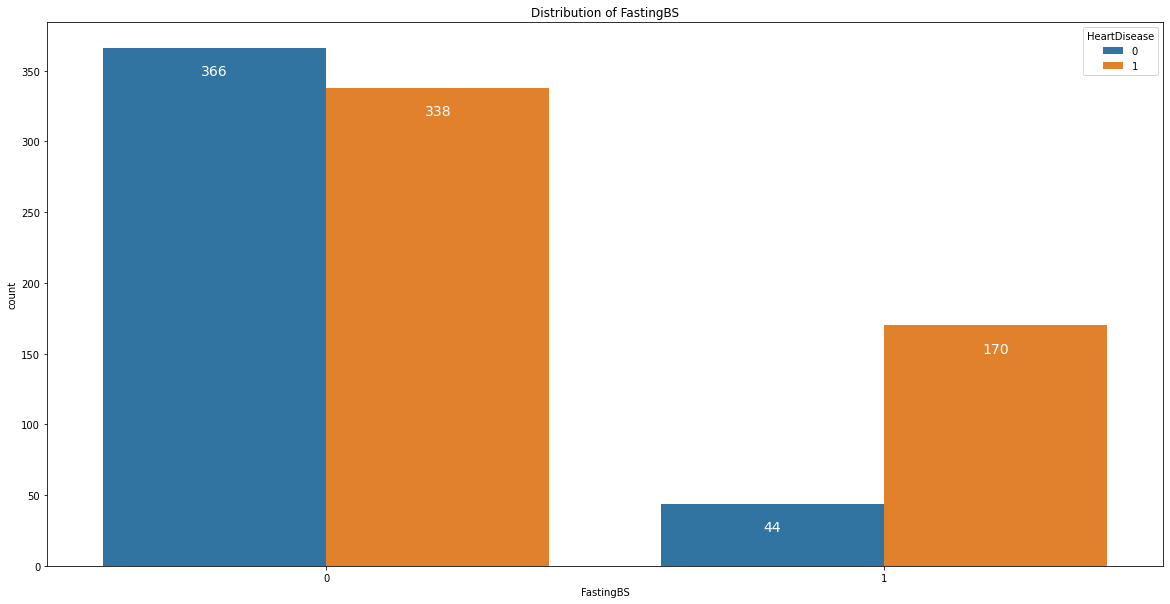

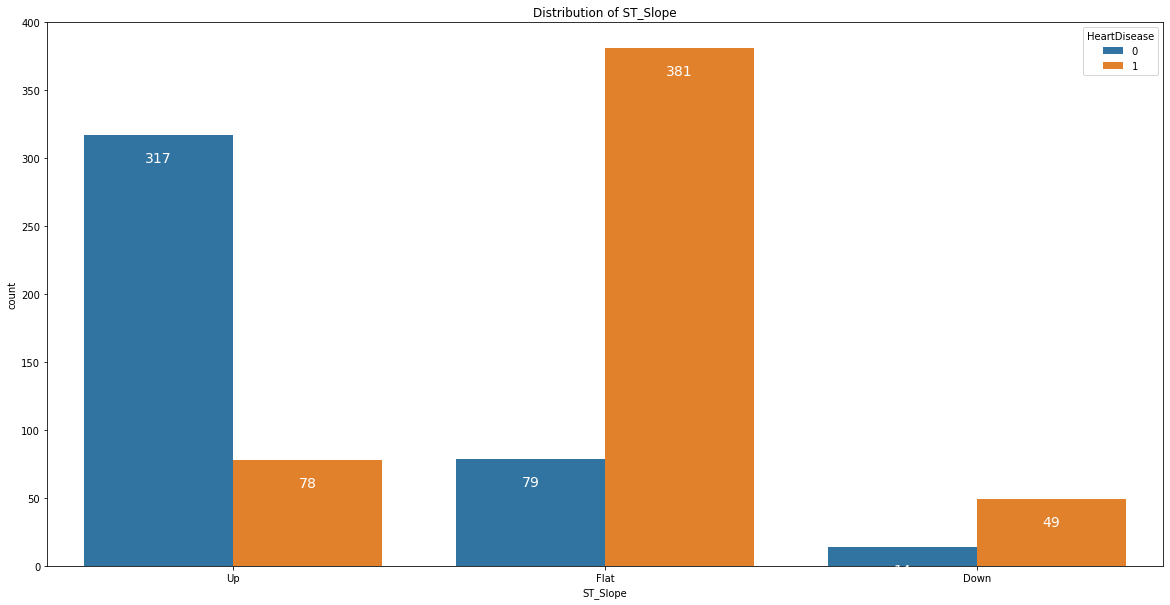

In [32]:
for categorical_feature in categorical_features[:-1]: 
    categorical_distribution_acording_to_target_value(categorical_feature)

#### ANOVA analysis

The idea of this analysis is to see if there is any connection between the target values and the different numerical variables.

In [33]:
for numerical_feauture in numerical_features:
    none_relevant_features = []
    p_value = 0.05
    anova_test = stats.f_oneway(data[f'{numerical_feauture}'][data['HeartDisease'] == 0], data[f'{numerical_feauture}'][data['HeartDisease'] == 1])
    if anova_test[1] > p_value:
        none_relevant_features.append(feature)

#### Chi analysis

The idea of this analysis is to see if there is any connection between the target values and the different categorical variables.

In [34]:
p_value = 0.05
for categorical_feature in categorical_features:
    ct = pd.crosstab(data[f'{categorical_feature}'], data['HeartDisease'], margins=True)
    ct = ct.drop("All", axis=1).drop("All", axis=0)
    obs = np.array(ct.values)
    if stats.chi2_contingency(obs)[0:3][1] > p_value:
        none_relevant_features.append(f'{categorical_feature}')
print(none_relevant_features) 

[]


#### Decistion Tree: Feature understanding

The idea is to train a decision tree to understand what are the variables that affect most the target value, or if any variable does not affect it

In [35]:
# Encoding:
decision_tree = data.copy()

object_cols = decision_tree.loc[:, data.dtypes == 'O']
object_type_columns = [col for col in object_cols.columns]

for column in object_type_columns:
    decision_tree[f'{column}'] = LabelEncoder().fit_transform(decision_tree[f'{column}'])
    
features_for_importance=decision_tree.columns.to_list()
features_for_importance.remove('HeartDisease')

In [36]:
clasifier = DecisionTreeClassifier()
clasifier.fit(decision_tree.loc[:, decision_tree.columns != 'HeartDisease'], decision_tree['HeartDisease'])

DecisionTreeClassifier()

Text(0.5, 0, 'Relative Importance')

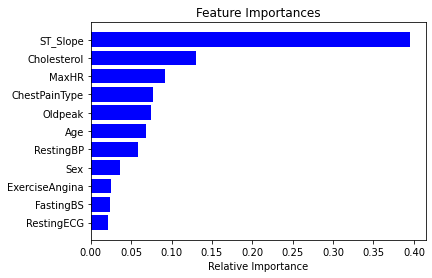

In [37]:
importances = clasifier.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(features_for_importance)[indices])
plt.xlabel('Relative Importance')

#### Correlations

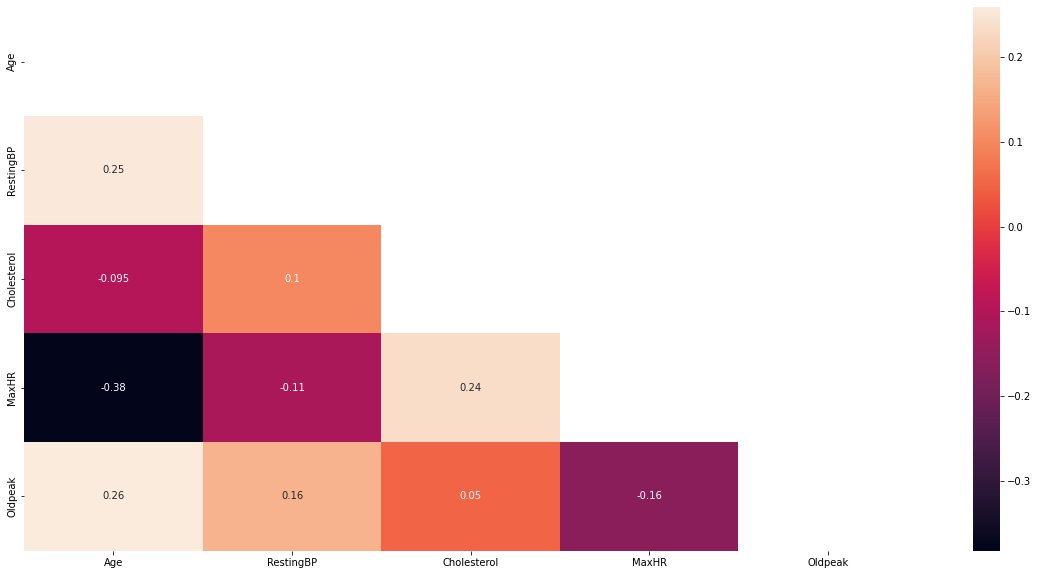

In [38]:
plt.figure(figsize=(20, 10))
matrix = np.triu(data[numerical_features].corr())
sns.heatmap(data[numerical_features].corr(), annot=True, mask=matrix)
plt.show()
plt.close()

In [39]:
data.corr().unstack().sort_values().drop_duplicates().head(10)

HeartDisease  MaxHR         -0.400421
Age           MaxHR         -0.382045
Cholesterol   FastingBS     -0.260974
HeartDisease  Cholesterol   -0.232741
Oldpeak       MaxHR         -0.160691
FastingBS     MaxHR         -0.131438
RestingBP     MaxHR         -0.112135
Age           Cholesterol   -0.095282
Cholesterol   Oldpeak        0.050148
FastingBS     Oldpeak        0.052698
dtype: float64

In [40]:
data.corr().unstack().sort_values().drop_duplicates().tail(10)

HeartDisease  RestingBP       0.107589
Oldpeak       RestingBP       0.164803
FastingBS     Age             0.198039
MaxHR         Cholesterol     0.235792
RestingBP     Age             0.254399
Age           Oldpeak         0.258612
HeartDisease  FastingBS       0.267291
              Age             0.282039
Oldpeak       HeartDisease    0.403951
Age           Age             1.000000
dtype: float64

#### Unsupervised learning for hidden patterns: UMAP

In [41]:
scaler = StandardScaler()

data_clustering = data.copy()

object_cols = data_clustering.loc[:, data_clustering.dtypes == 'O']
object_type_columns = [col for col in object_cols.columns]

for column in object_type_columns:
    data_clustering[f'{column}'] = LabelEncoder().fit_transform(data_clustering[f'{column}'])
data_clustering = scaler.fit_transform(data_clustering.loc[:, data.columns != 'HeartDisease'])

In [42]:
umap_embeding = umap.UMAP(random_state=42).fit_transform(data_clustering)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [43]:
for n_of_components in range(0,12):
    pca = PCA(n_components=n_of_components)
    pca_embeding = pca.fit_transform(data_clustering)
    print(f'Number of Components :{n_of_components}, {pca.explained_variance_ratio_.sum()}')

Number of Components :0, 0.0
Number of Components :1, 0.25139664590150884
Number of Components :2, 0.3844855433522383
Number of Components :3, 0.4896146744054368
Number of Components :4, 0.5805042327575685
Number of Components :5, 0.6596718447968662
Number of Components :6, 0.7366239079232442
Number of Components :7, 0.8099544767246709
Number of Components :8, 0.8667098245270437
Number of Components :9, 0.917376099891894
Number of Components :10, 0.9629480442797336
Number of Components :11, 1.0000000000000004


In [44]:
pca = PCA(n_components=2)
pca_embeding = pca.fit_transform(data_clustering)
print(pca.explained_variance_ratio_.sum())

0.38448554335223795


In [45]:
kmeans_true_labels = cluster.KMeans(n_clusters=2).fit_predict(data_clustering)
kmeans_umap_labels = cluster.KMeans(n_clusters=2).fit_predict(umap_embeding
                                                              [:, 0].reshape(-1, 1), umap_embeding[:, 1].reshape(-1, 1))
kmeans_pca_labels = cluster.KMeans(n_clusters=2).fit_predict(pca_embeding[:, 0].reshape(-1, 1), pca_embeding[:, 1].reshape(-1, 1))

In [46]:
def scatter_plot(axis1, axis2, color, title, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.scatter(axis1, axis2, c=color, cmap='Pastel1')
    plt.title(f'{title}')
    plt.xlabel(f'{xlabel}')
    plt.ylabel(f'{ylabel}')
    plt.show()
    plt.close()

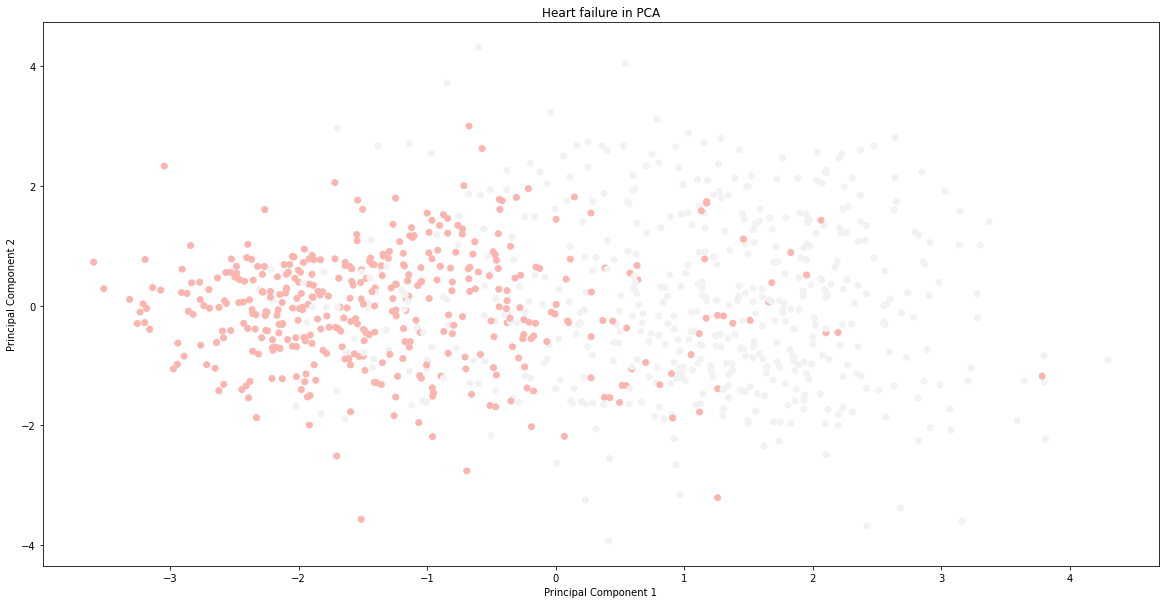

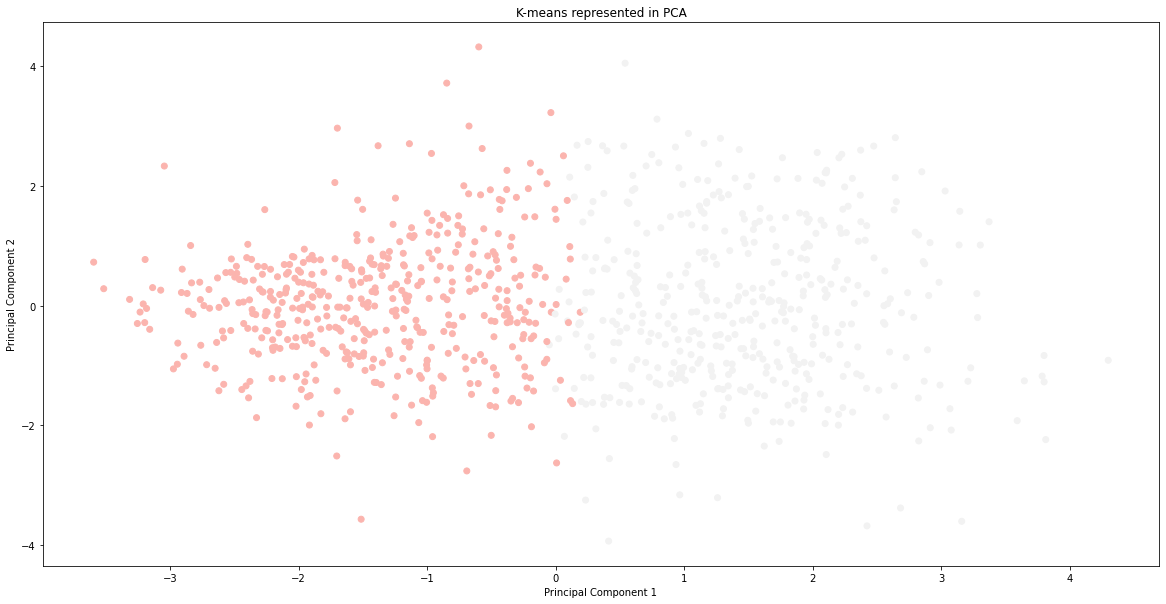

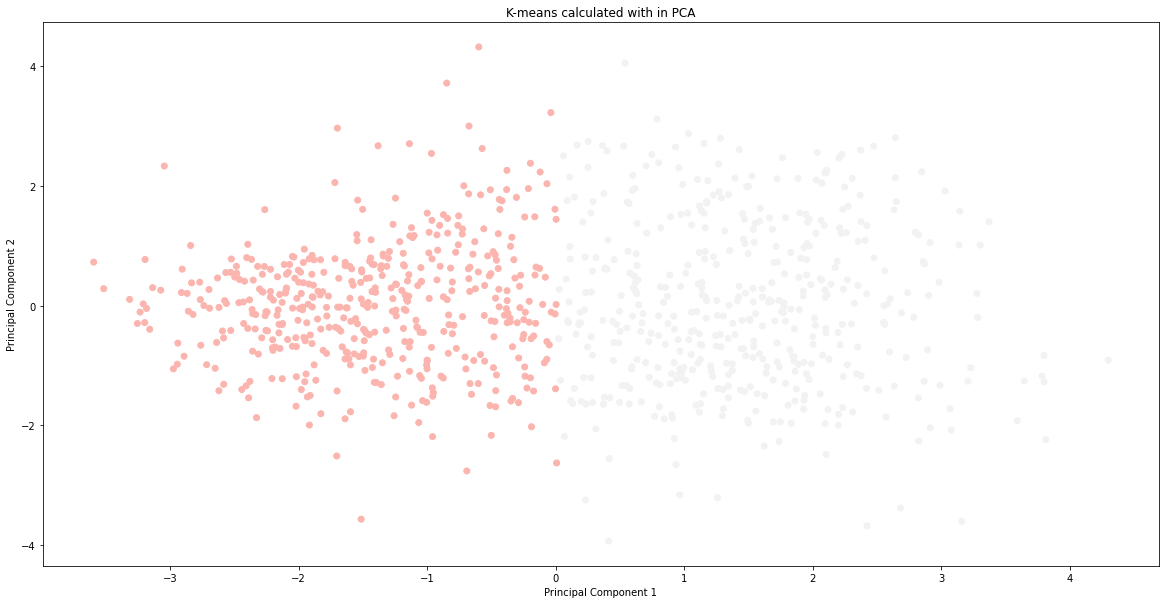

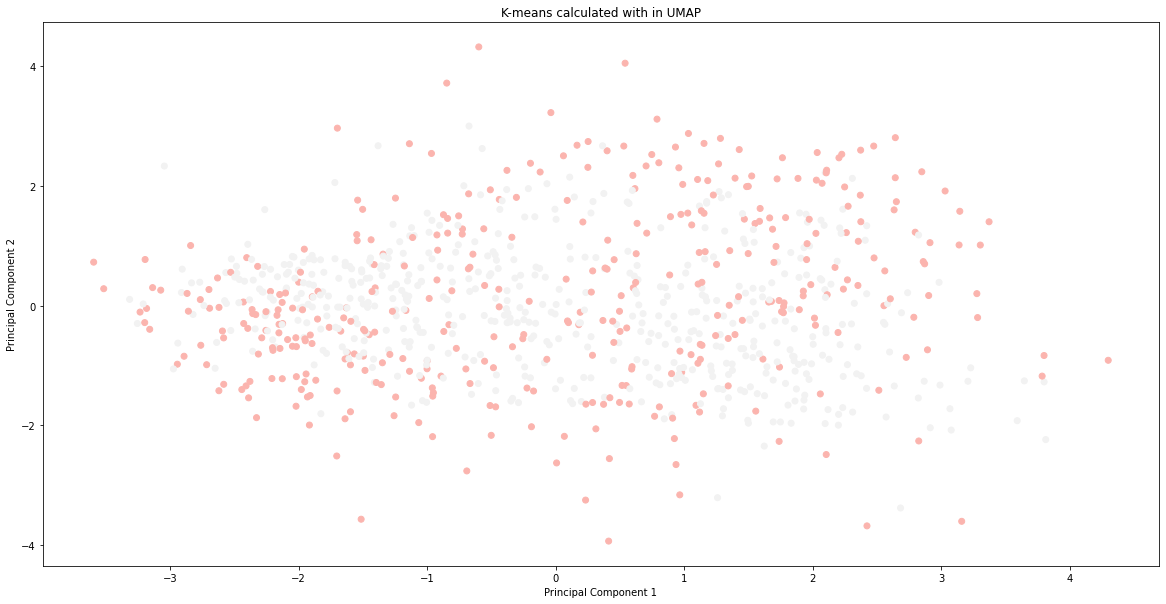

In [47]:
scatter_plot(axis1=pca_embeding[:, 0].reshape(-1, 1),
            axis2=pca_embeding[:, 1].reshape(-1, 1),
            color=data['HeartDisease'],
            title='Heart failure in PCA', 
            xlabel='Principal Component 1',
            ylabel='Principal Component 2')
scatter_plot(axis1=pca_embeding[:, 0].reshape(-1, 1),
            axis2=pca_embeding[:, 1].reshape(-1, 1),
            color=kmeans_true_labels,
            title='K-means represented in PCA',
            xlabel='Principal Component 1',
            ylabel='Principal Component 2')
scatter_plot(axis1=pca_embeding[:, 0].reshape(-1, 1),
            axis2=pca_embeding[:, 1].reshape(-1, 1),
            color=kmeans_pca_labels,
            title='K-means calculated with in PCA',
            xlabel='Principal Component 1',
            ylabel='Principal Component 2')
scatter_plot(axis1=pca_embeding[:, 0].reshape(-1, 1),
            axis2=pca_embeding[:, 1].reshape(-1, 1),
            color=kmeans_umap_labels,
            title='K-means calculated with in UMAP',
            xlabel='Principal Component 1',
            ylabel='Principal Component 2')

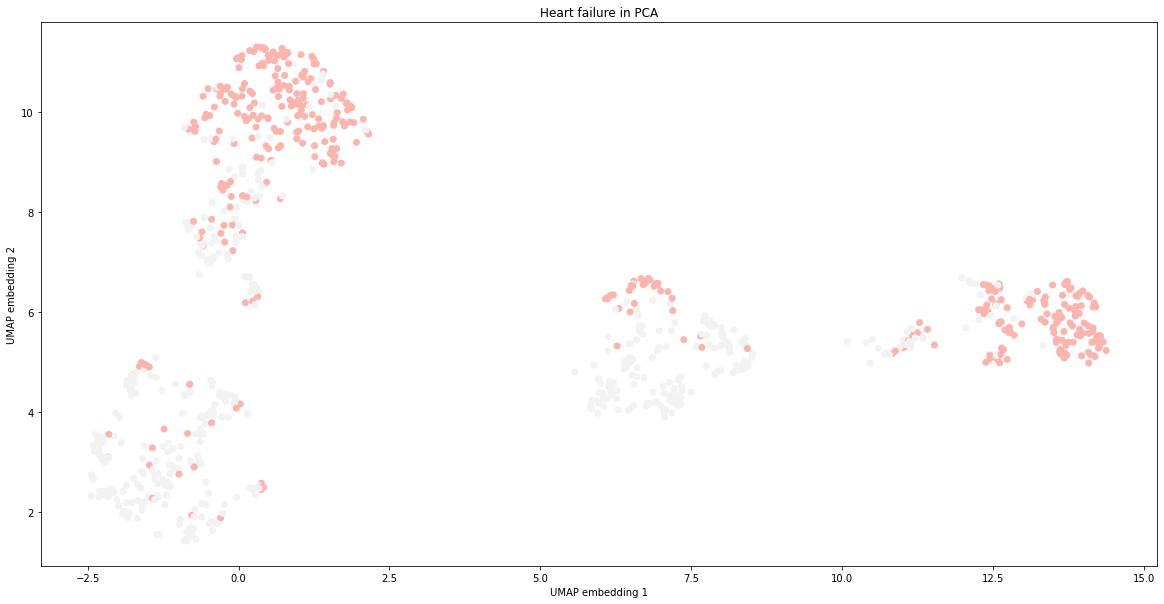

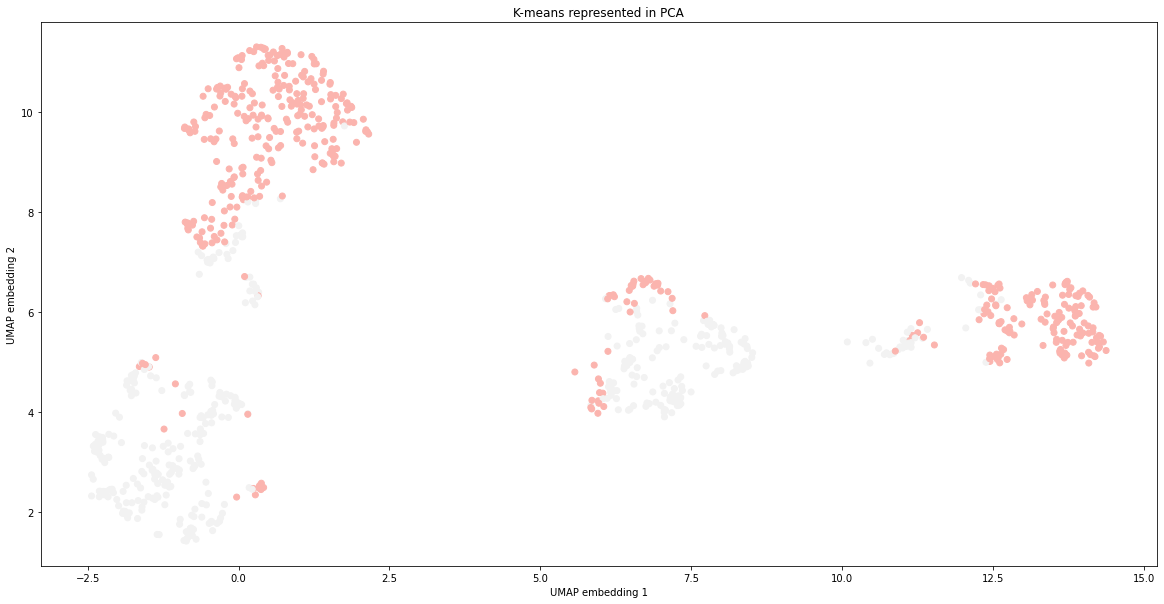

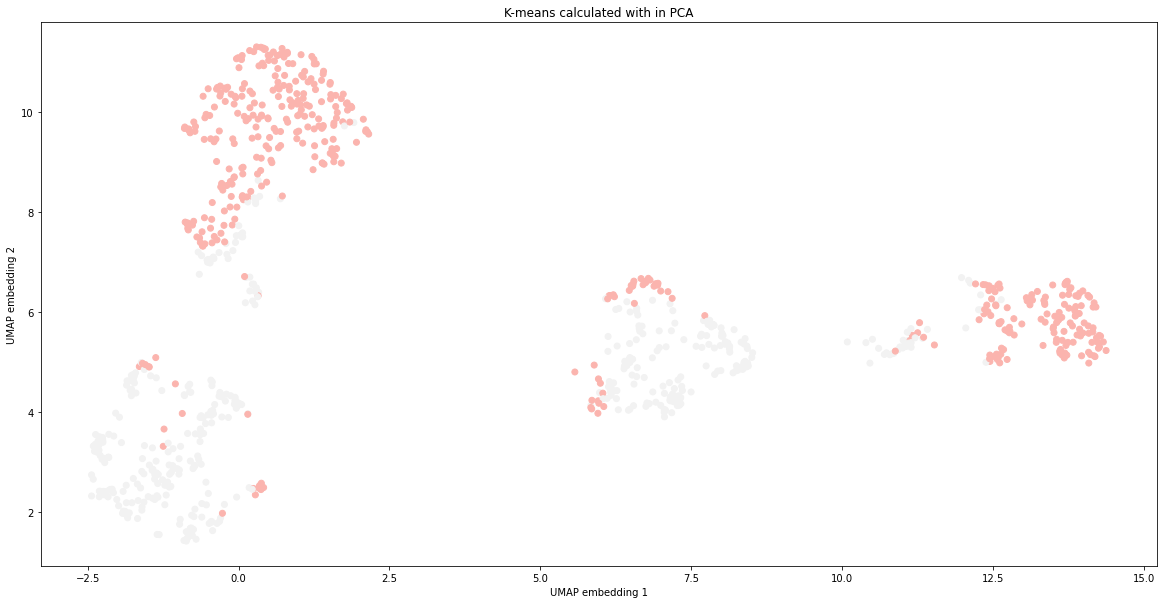

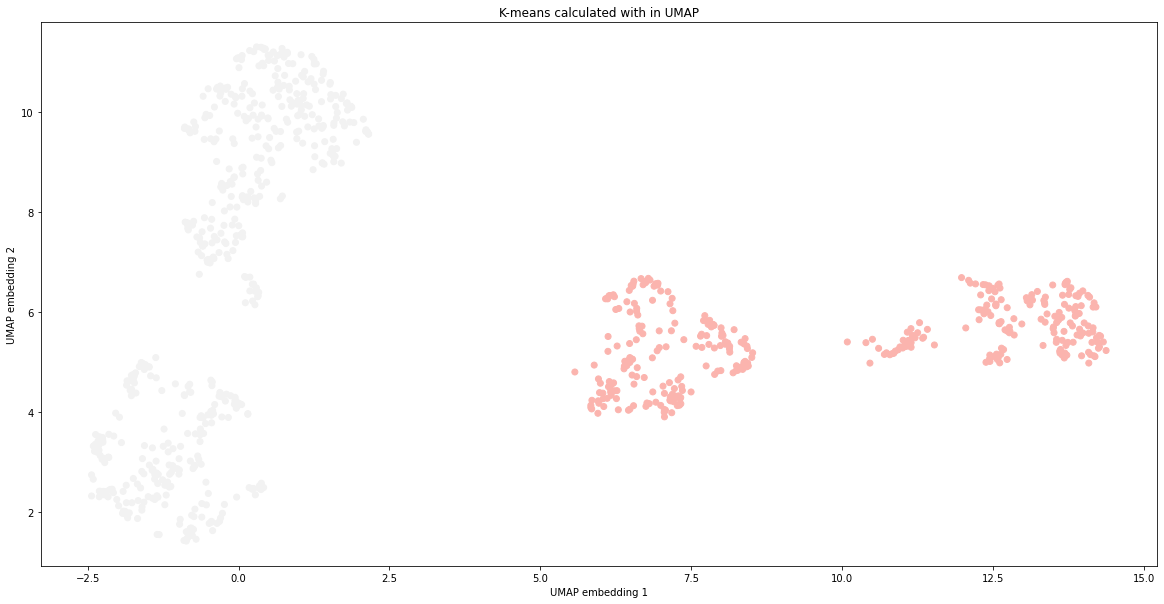

In [48]:
scatter_plot(axis1=umap_embeding[:, 0].reshape(-1, 1),
            axis2=umap_embeding[:, 1].reshape(-1, 1),
            color=data['HeartDisease'],
            title='Heart failure in PCA', 
            xlabel='UMAP embedding 1',
            ylabel='UMAP embedding 2')
scatter_plot(axis1=umap_embeding[:, 0].reshape(-1, 1),
            axis2=umap_embeding[:, 1].reshape(-1, 1),
            color=kmeans_true_labels,
            title='K-means represented in PCA',
            xlabel='UMAP embedding 1',
            ylabel='UMAP embedding 2')
scatter_plot(axis1=umap_embeding[:, 0].reshape(-1, 1),
            axis2=umap_embeding[:, 1].reshape(-1, 1),
            color=kmeans_pca_labels,
            title='K-means calculated with in PCA',
            xlabel='UMAP embedding 1',
            ylabel='UMAP embedding 2')
scatter_plot(axis1=umap_embeding[:, 0].reshape(-1, 1),
            axis2=umap_embeding[:, 1].reshape(-1, 1),
            color=kmeans_umap_labels,
            title='K-means calculated with in UMAP',
            xlabel='UMAP embedding 1',
            ylabel='UMAP embedding 2')

In [49]:
def get_results(label, method, method_name):
    """
    df = pd.DataFrame(list(zip(label, method)), columns =['Label', f'{method_name}'])
    print(df)
    print(df.groupby([f'{method_name}']).count())
    print(df.groupby([f'Label', f'{method_name}']))
    """
    print(method_name)
    cm = confusion_matrix(label, method)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

k means


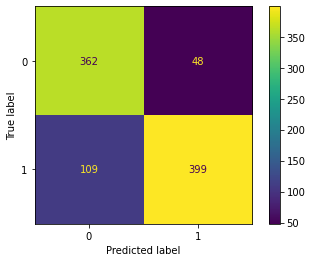

k means PCA


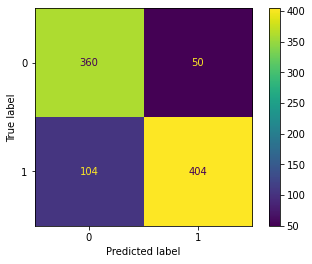

k means UMAP


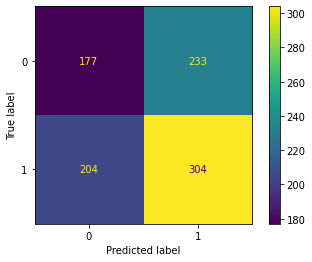

In [50]:
get_results(data['HeartDisease'], kmeans_true_labels, 'k means')
get_results(data['HeartDisease'], kmeans_pca_labels, 'k means PCA')
get_results(data['HeartDisease'], kmeans_umap_labels, 'k means UMAP')

### EDA: Conclusions

More than one dataset has been created, depending on different decissions that have been taken in different phases of the EDA. 


## Modeling

### Feature Engineering

### Dataset spliting

In [51]:
def data_spliter(data):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(['HeartDisease'], axis=1),
                                                        decision_tree['HeartDisease'],
                                                        test_size=0.2,train_size=0.8)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,train_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

### Hyperparameter tuning

The idea behind this hyperparameter tunning is to work with the validation and traning dataset to ensure that the hyperparameters of this algorithms are best suited.

Overfitting and underfitting will also be checked by checking the difference in metrics between the training and validation results. 

In [52]:
def load_best_hyperparameters(algorithm, search_method):
    path_to_file = pathlib.Path(f'{base_path}/modeling/hyperparamters/{algorithm}_{search_method}.pickle')
    if path_to_file.is_file():
        with open(str(path_to_file), 'rb') as handle:
            best_hyperparameters = pickle.load(handle)
    else:
        best_hyperparameters = {}
    return best_hyperparameters

In [53]:
def save_best_hyperparameters(hyperparameters, algorithm, search_method):
    path_to_file = pathlib.Path(f'{base_path}/modeling/hyperparamters/{algorithm}_{search_method}.pickle')
    with open(str(path_to_file), 'wb') as handle:
        best_hyperparameters = pickle.dump(hyperparameters, handle)

In [54]:
def tune_hyperparameters(X, y, algorithm='None', save_tuning=True, load_tunining=False, search_method='grid_search', model=GaussianNB(), parameter_grid={}):
    if not load_tunining:
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        grid_search = GridSearchCV(estimator=model,
                                   param_grid=parameter_grid, n_jobs=-1, cv=cv,
                                   scoring='f1',error_score=0)
        grid_result = grid_search.fit(X, y)
        print(f"Best F1 for hyperparameter tuning: {grid_result.best_score_}")
        result = grid_result.best_params_
        if save_tuning: # save the results
            save_best_hyperparameters(result, algorithm, search_method)
    else:
        result = load_best_hyperparameters(algorithm, search_method)
    return result

In [55]:
def tune_naive_bayes(hyperparameter_tuning=False, search_method='grid_search', tuning_parameters={}): # grid search and genetic algorithm
    if hyperparameter_tuning:
        pass
    else:
        clf = GaussianNB()
    return clf

#### KNN

In [56]:
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
knn_grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
knn_best_hyperparameters = tune_hyperparameters(X=decision_tree.drop(['HeartDisease'], axis=1),
                                                y=decision_tree['HeartDisease'],
                                                algorithm='knn',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=KNeighborsClassifier(),
                                                parameter_grid=knn_grid)
print(f'Hyperparameter for KNN are {knn_best_hyperparameters}')

Best F1 for hyperparameter tuning: 0.7799344289775721
Hyperparameter for KNN is {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}


#### Logistic Regression

In [91]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
lr_grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter=[1000])

lr_best_hyperparameters = tune_hyperparameters(X=decision_tree.drop(['HeartDisease'], axis=1),
                                                y=decision_tree['HeartDisease'],
                                                algorithm='lr',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=LogisticRegression(),
                                                parameter_grid=lr_grid)
print(f'Hyperparameter for Logistic Regression are {lr_best_hyperparameters}')

Best F1 for hyperparameter tuning: 0.8674730579989628
Hyperparameter for Logistic Regression are {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}


#### SVC

In [93]:
kernel = ['poly', 'rbf', 'sigmoid']
c_values = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
svc_grid = dict(kernel=kernel, gamma=gamma,C=c_values, max_iter=[1000])

svc_best_hyperparameters = tune_hyperparameters(X=decision_tree.drop(['HeartDisease'], axis=1),
                                                y=decision_tree['HeartDisease'],
                                                algorithm='svc',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=SVC(),
                                                parameter_grid=svc_grid)
print(f'Hyperparameter for Support Vector Clasiffier are {svc_best_hyperparameters}')

Best F1 for hyperparameter tuning: 0.8151298548007185
Hyperparameter for Support Vector Clasiffier are {'C': 50, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 1000}


Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


#### Random Forest

In [94]:
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
rfc_grid = dict(n_estimators=n_estimators, max_features=max_features)

rfc_best_hyperparameters = tune_hyperparameters(X=decision_tree.drop(['HeartDisease'], axis=1),
                                                y=decision_tree['HeartDisease'],
                                                algorithm='rfc',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=RandomForestClassifier(),
                                                parameter_grid=rfc_grid)
print(f'Hyperparameter for Random Forest Clasiffier are {rfc_best_hyperparameters}')

Best F1 for hyperparameter tuning: 0.8860369893553817
Hyperparameter for Support Vector Clasiffier are {'C': 50, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 1000}


/Users/cocotero/Documents/mai/heart-failure/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/cocotero/Documents/mai/heart-failure/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/cocotero/Documents/mai/heart-failure/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/cocotero/Documents/mai/heart-failure/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

#### XGBoost

In [ ]:
max_depth = [3, 5, 6, 10, 15, 20]
learning_rate = [0.01, 0.1, 0.2, 0.3]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)
n_estimators = [10, 100, 1000]

xgb_grid = dict(max_depth=max_depth, learning_rate=learning_rate, subsample=subsample,
                colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, n_estimators=n_estimators)

xgb_best_hyperparameters = tune_hyperparameters(X=decision_tree.drop(['HeartDisease'], axis=1),
                                                y=decision_tree['HeartDisease'],
                                                algorithm='xgb',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=RandomForestClassifier(),
                                                parameter_grid=xgb_grid)
print(f'Hyperparameter for XBoost are {xgb_best_hyperparameters}')

#### Ada Boost

In [ ]:
max_depth = [3, 5, 6, 10, 15, 20]
learning_rate = [0.01, 0.1, 0.2, 0.3]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)
n_estimators = [10, 100, 1000]

adab_grid = dict(max_depth=max_depth, learning_rate=learning_rate, subsample=subsample,
                colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, n_estimators=n_estimators)

adab_best_hyperparameters = tune_hyperparameters(X=decision_tree.drop(['HeartDisease'], axis=1),
                                                 y=decision_tree['HeartDisease'],
                                                 algorithm='adaboost',
                                                 save_tuning=True,
                                                 load_tunining=False,
                                                 search_method='grid_search',
                                                 model=xgb.XGBClassifier(),
                                                 parameter_grid=adab_grid)
print(f'Hyperparameter for Ada Boost are {adab_best_hyperparameters}')

[13:56:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:56:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:56:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:56:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

/Users/cocotero/Documents/mai/heart-failure/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cocotero/Documents/mai/heart-failure/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cocotero/Document

[13:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

/Users/cocotero/Documents/mai/heart-failure/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cocotero/Documents/mai/heart-failure/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cocotero/Document

[13:56:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:56:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:56:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:56:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

/Users/cocotero/Documents/mai/heart-failure/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cocotero/Documents/mai/heart-failure/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cocotero/Document

[13:58:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

/Users/cocotero/Documents/mai/heart-failure/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cocotero/Documents/mai/heart-failure/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cocotero/Document

#### Gradient Boost

#### Light Gradient Boost Classifier

In [63]:
naive_bayes_clf = tune_naive_bayes(True, {})
logistic_regression_clf = LogisticRegression(random_state=0)
nearest_neighbors_clf = tune_nearest_neighbors()
clf = NearestNeighbors(n_neighbors=2)
clf = svm.SVC()

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf = xgb.XGBClassifier()
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf = GradientBoostingClassifier()
clf = LGBMClassifier()

# Neural Net - pytorch

UnboundLocalError: local variable 'clf' referenced before assignment

### Traning

In [77]:
knn_model = KNeighborsClassifier(metric=knn_best_hyperparameters.get('metric'), 
                                 n_neighbors=knn_best_hyperparameters.get('n_neighbors'),
                                 weights=knn_best_hyperparameters.get('weights'))
knn_model.fit(X=decision_tree.drop(['HeartDisease'], axis=1), y=decision_tree['HeartDisease'])

KNeighborsClassifier(metric='manhattan', n_neighbors=17, weights='distance')

#### Logistic Regression

In [ ]:
def train_logistic_regression():
    if hyperparameter_tuning_train:
        a
    elif :  # None empty
        model = LogisticRegression()
    else:
        model = LogisticRegression()
    return model

## Results

### Results benchmark

In [69]:
decision_tree

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


### Model explainabilty

In [74]:
X_train = decision_tree.iloc[0:800,:]
X_train.drop(['HeartDisease'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [75]:
X_valid = decision_tree.iloc[800:,:]
X_valid.drop(['HeartDisease'], axis=1, inplace=True)

In [78]:
f = lambda x: knn_model.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_valid.iloc[0:1000,:])

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with fe

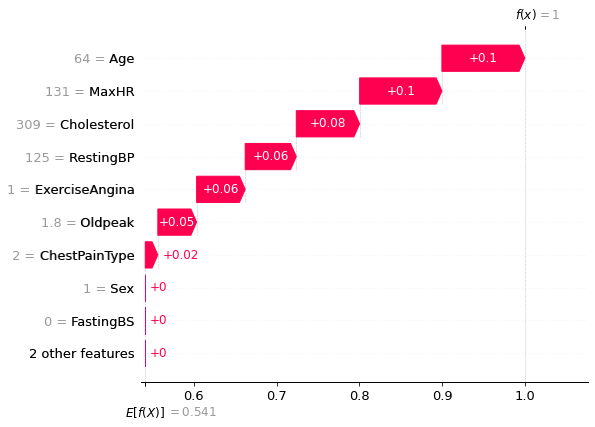

In [89]:
shap.plots.waterfall(shap_values[23]) #num of patient 0-118

In [ ]:
"""
Hyperparameter for KNN is {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}

"""
knn_model.
a

explainer = shap.Explainer(knn_model)
shap_values = explainer(decision_tree.drop(['HeartDisease'], axis=1))
shap.plots.waterfall(shap_values[0])